In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import berserk
import os
import random
from tqdm import tqdm
from itertools import chain
from collections import Counter
from scipy import stats

In [2]:
#extract usernames as list:
with open("../data/usernames_2024-08.txt", "r") as file:
    usernames = file.read().split(",")
random.seed(1)
users_sample = random.sample(usernames, k=5000)

In [3]:
api_token = os.environ.get('LICHESS_API_TOKEN')
session = berserk.TokenSession(api_token)
client = berserk.Client(session)

In [5]:
proportions_blitz = []
for user in tqdm(users_sample):
    try:
        game_mode_data = pd.DataFrame(client.users.get_public_data(user)["perfs"])
        total_games = game_mode_data.loc["games",:].sum()
        # calculate proportion of blitz games
        if "blitz" in game_mode_data.columns:
            prop_blitz = game_mode_data.loc["games","blitz"]/total_games
            proportions_blitz.append(prop_blitz)
        else:
            proportions_blitz.append(0)
    except KeyError:
        pass

100%|██████████| 5000/5000 [24:58<00:00,  3.34it/s]


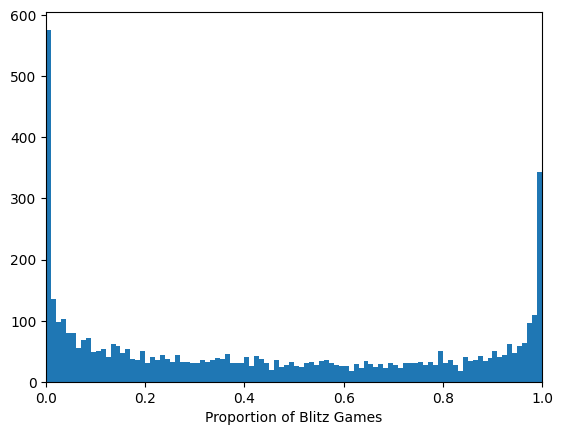

In [35]:
_ = plt.hist(proportions_blitz, bins=100)
_ = plt.xlabel("Proportion of Blitz Games")
_ = plt.xlim(0,1)

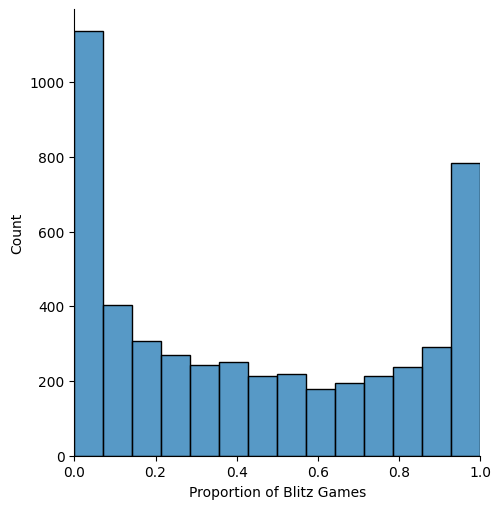

In [14]:
_ = sns.displot(proportions_blitz, kind="hist")
_ = plt.xlabel("Proportion of Blitz Games")
_ = plt.xlim(0,1)

In [3]:
all_ratings = pd.DataFrame()
all_games = pd.DataFrame()
for user in tqdm(users_sample[:50]):
    try:
        user_history = client.users.get_rating_history(user)
        for i in range(len(user_history)):
            game_mode_ratings = pd.DataFrame(user_history[i]["points"])
            if game_mode_ratings.shape[0] > 0:
                game_mode_ratings.insert(0, "username", user)
                game_mode_ratings['month'] += 1  # because months in lichess API start at 0 we have to increment by 1
                game_mode_ratings["mode"] = user_history[i]["name"]
                all_ratings = pd.concat([all_ratings, game_mode_ratings])
        user_games = pd.DataFrame(list(client.games.export_by_player(user, perf_type="blitz", max=500)))
        user_games.insert(0, "username", user)
        all_games = pd.concat([all_games, user_games])
    except KeyError:
      pass
    except berserk.exceptions.ResponseError:
      pass

NameError: name 'users_sample' is not defined

In [35]:
all_ratings.shape

(31235, 6)

In [34]:
all_games.shape

(17016, 17)

In [4]:
all_ratings = pd.read_csv("../data/all_ratings_users_active_in_Aug24.csv")

In [6]:
all_ratings["date"] = pd.to_datetime(all_ratings[all_ratings.columns[1:4]])
all_ratings = all_ratings.drop(labels=["year","month","day"], axis=1)
all_ratings = all_ratings.sort_values(["username", "date"])
all_ratings = all_ratings.reset_index(drop=True)

In [7]:
all_ratings["date_prev_activity"] = all_ratings["date"].shift(1)
all_ratings["days_since_prev"] = (all_ratings["date"] - all_ratings["date_prev_activity"])/ np.timedelta64(1, 'D')
all_ratings.loc[all_ratings.groupby('username')['date'].idxmin(), 'days_since_prev'] = np.nan

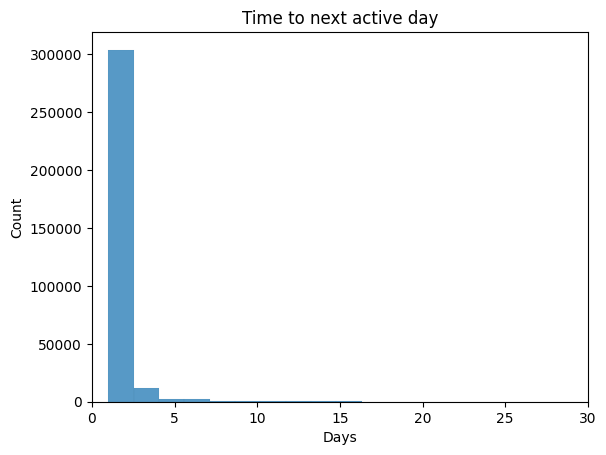

In [8]:
_ = sns.histplot([rating for rating in all_ratings["days_since_prev"] if rating>0], bins = 2000)
_ = plt.xlim(0,30)
_ = plt.title("Time to next active day")
_ = plt.xlabel("Days")

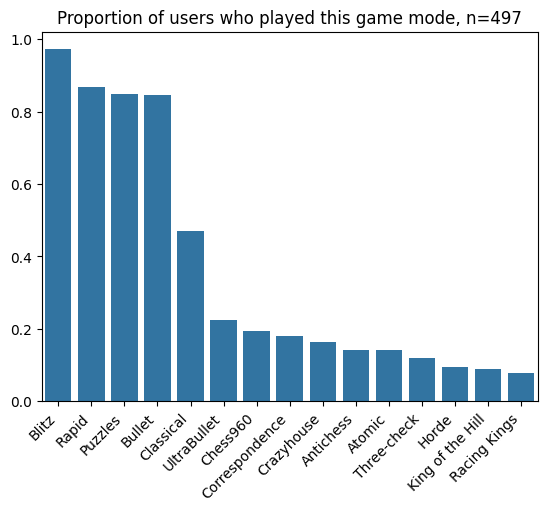

In [22]:
game_mode_frequency = dict(Counter(chain(*map(list, all_ratings.groupby("username")["mode"].unique()))))
game_mode_frequency_desc = dict(sorted(game_mode_frequency.items(),key= lambda x: x[1], reverse=True))
n = len(all_ratings["username"].unique())
_ = sns.barplot(x=game_mode_frequency_desc.keys(),y=map(lambda x: x/n, game_mode_frequency_desc.values()))
_ = plt.xticks(rotation=45, ha="right")
_ = plt.title(f"Proportion of users who played this game mode, n={n}")

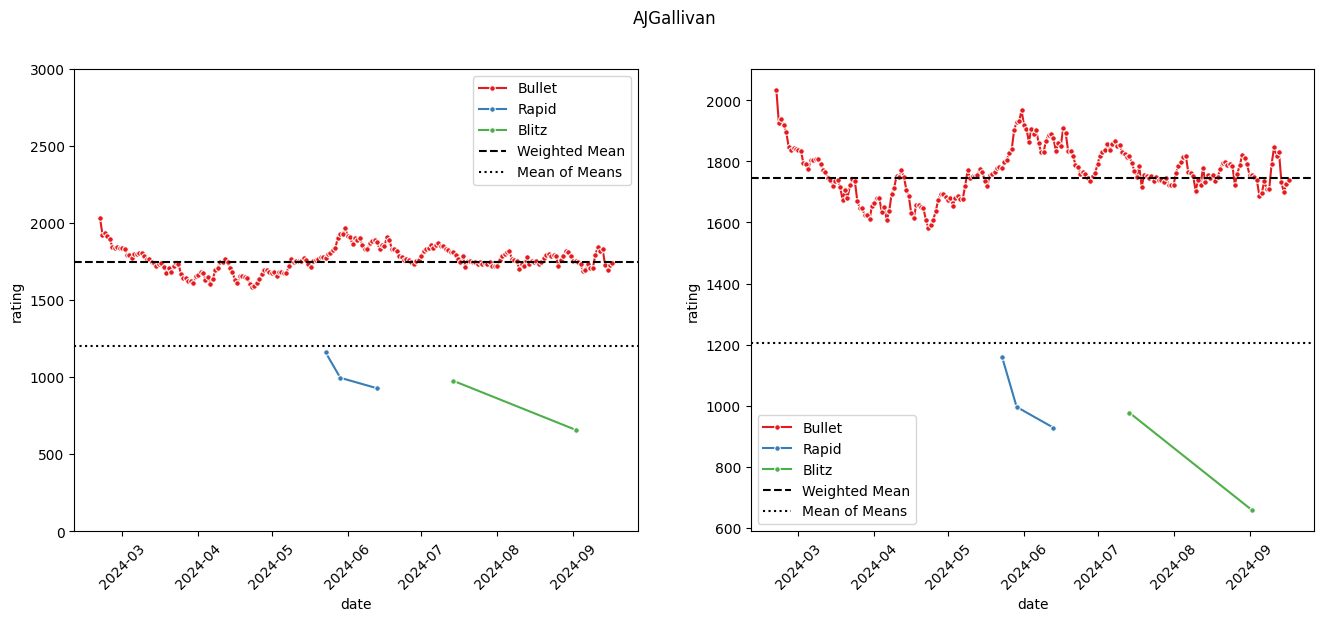

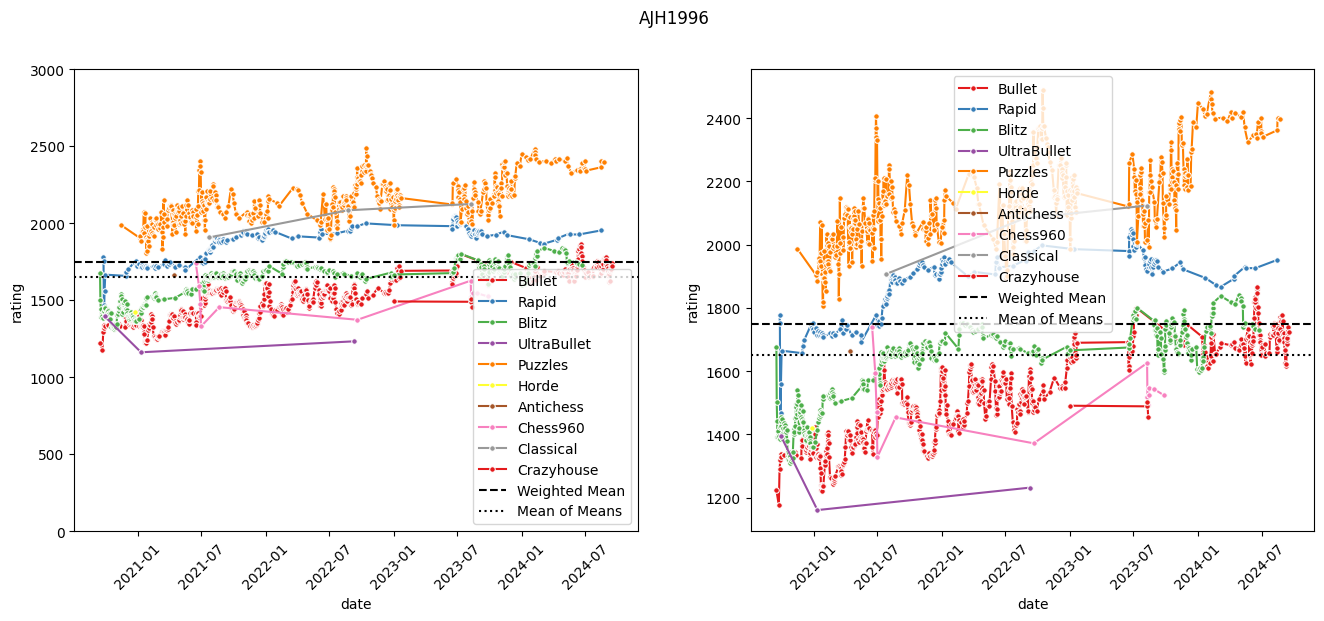

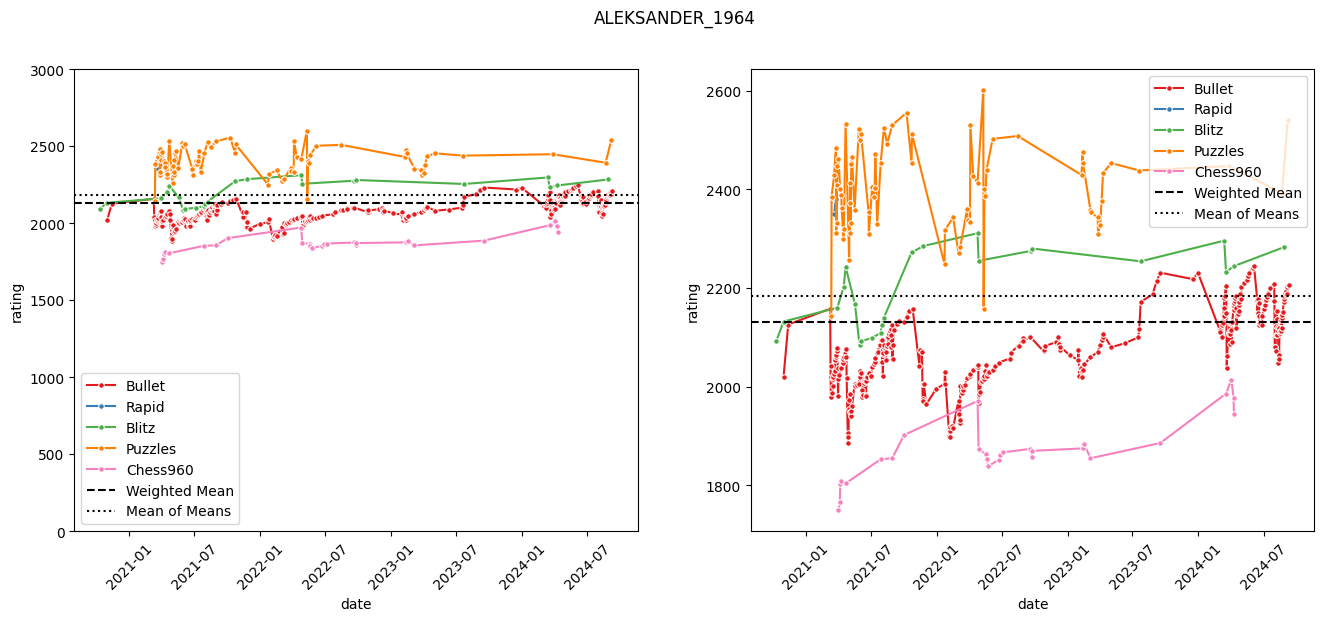

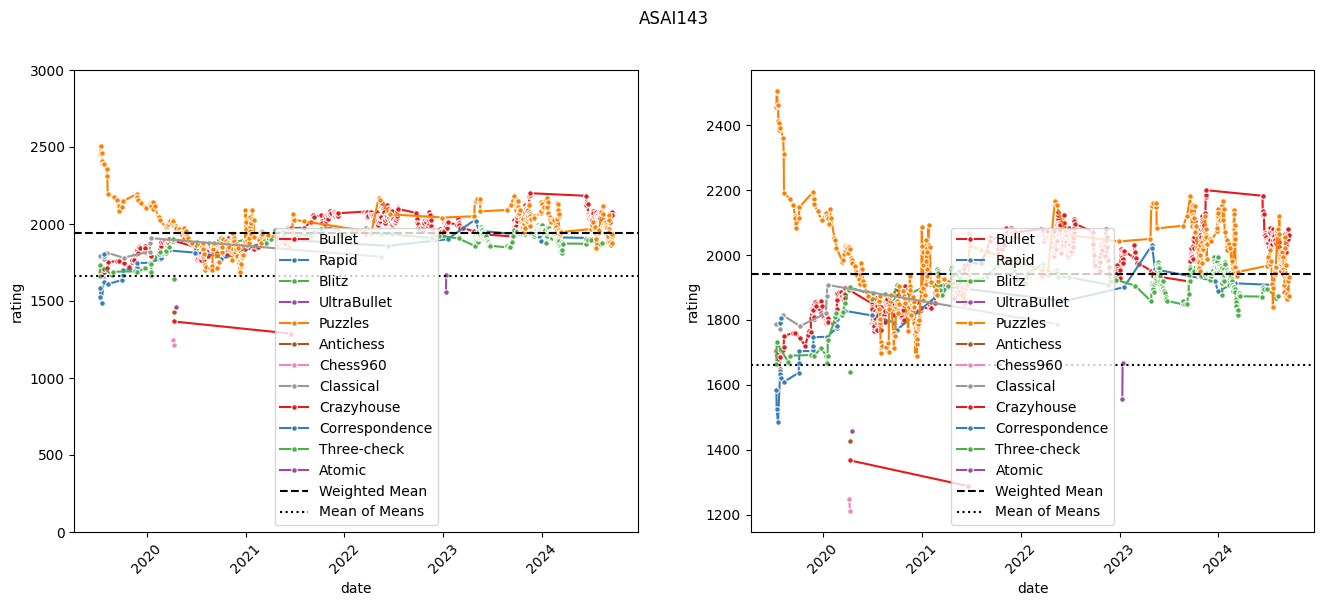

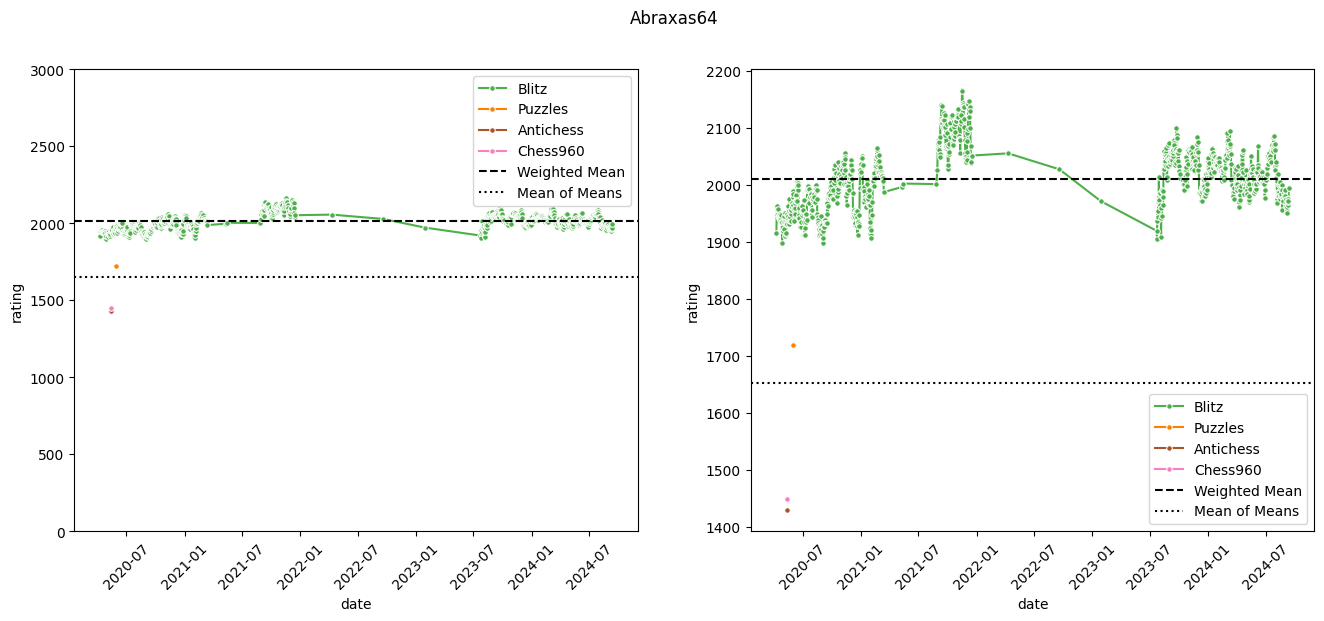

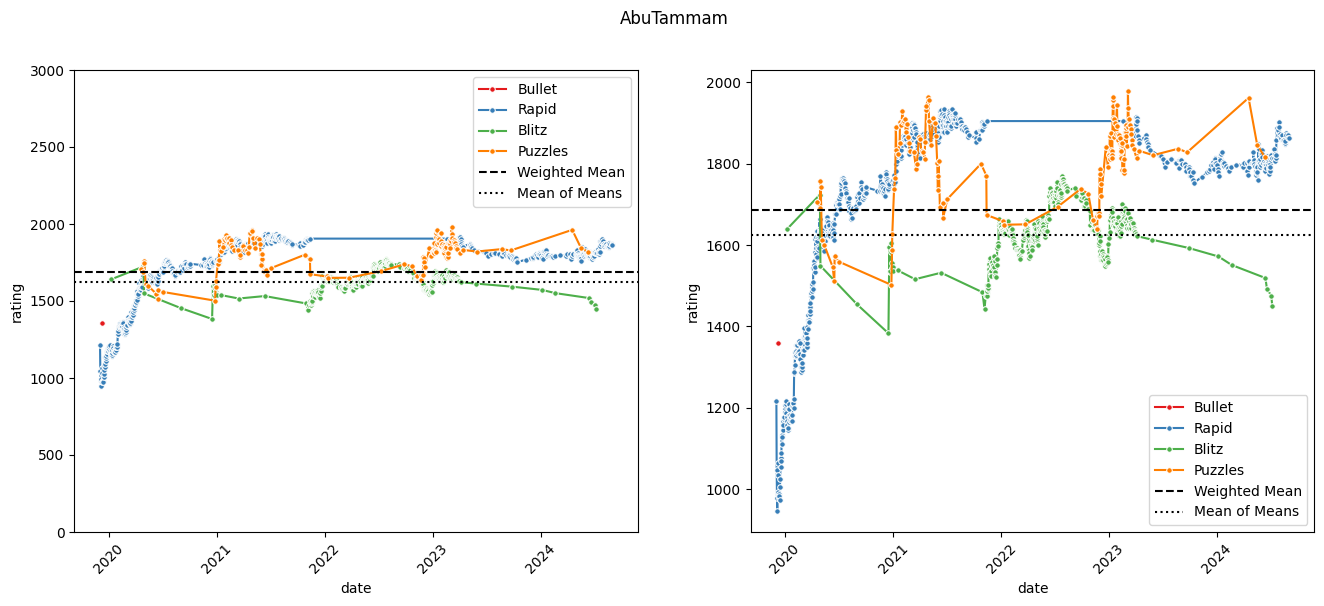

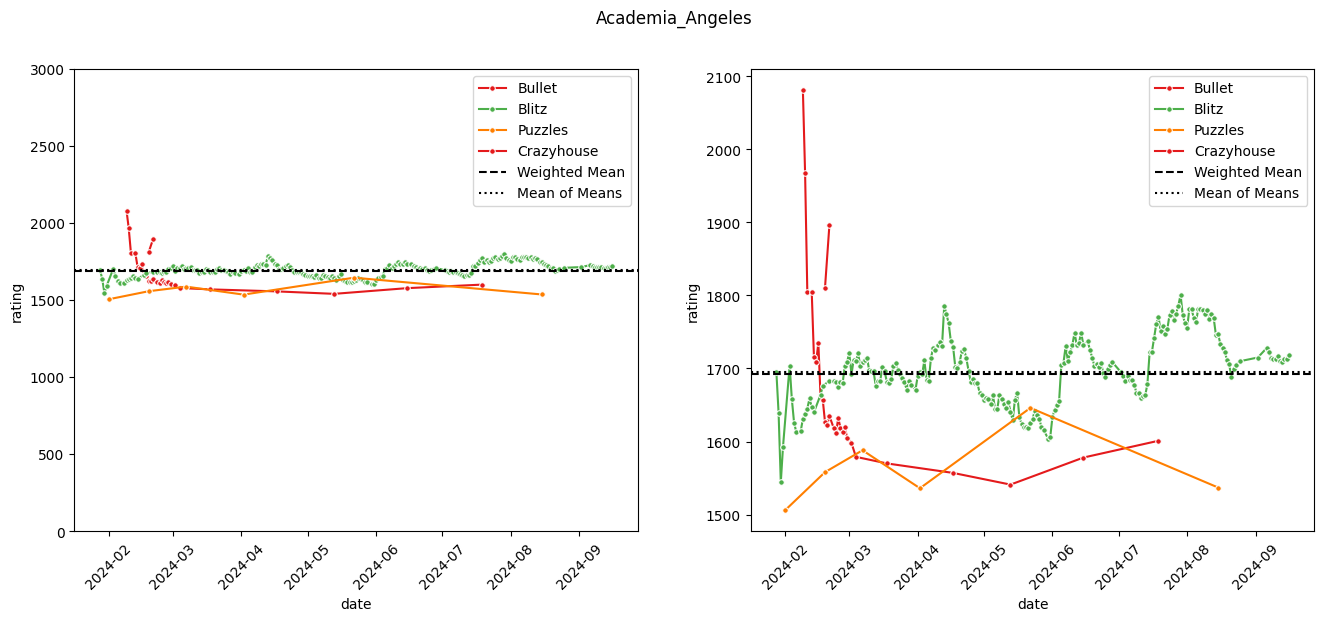

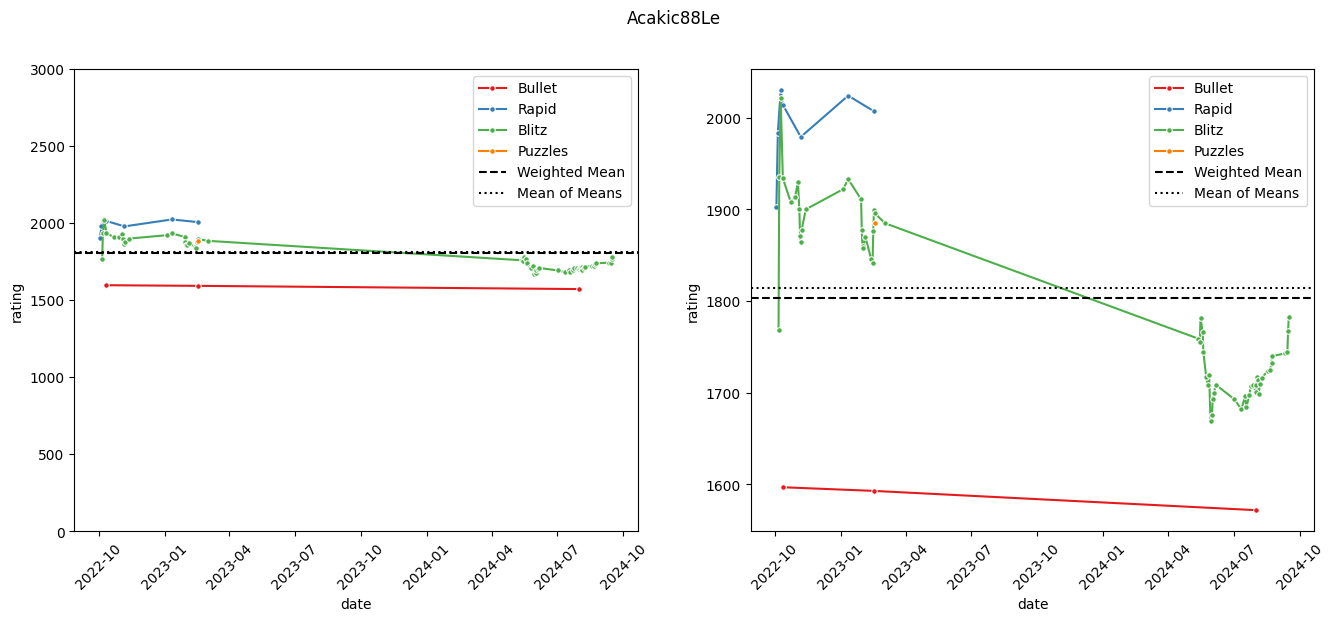

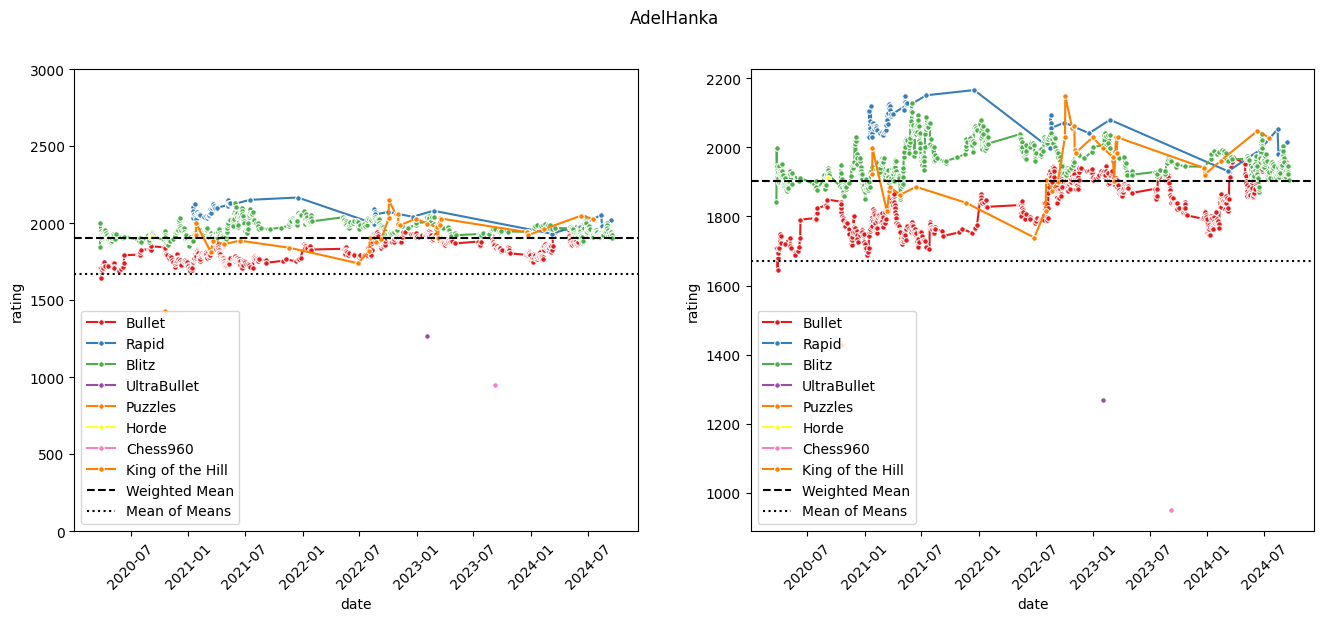

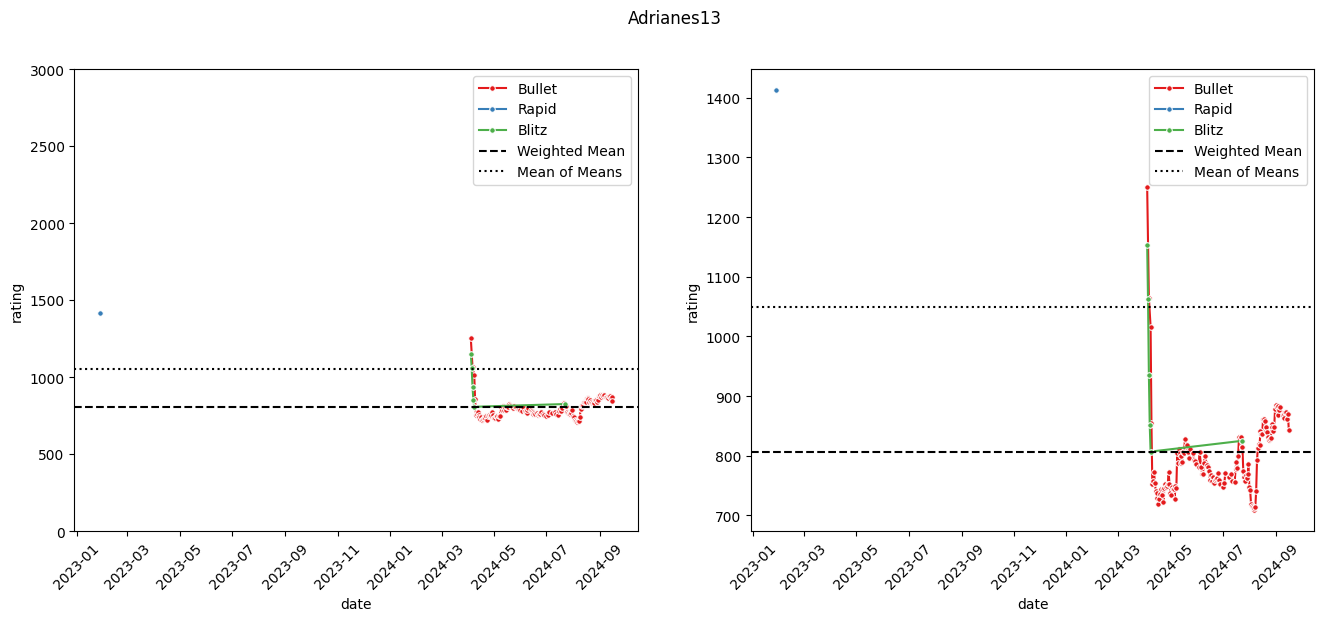

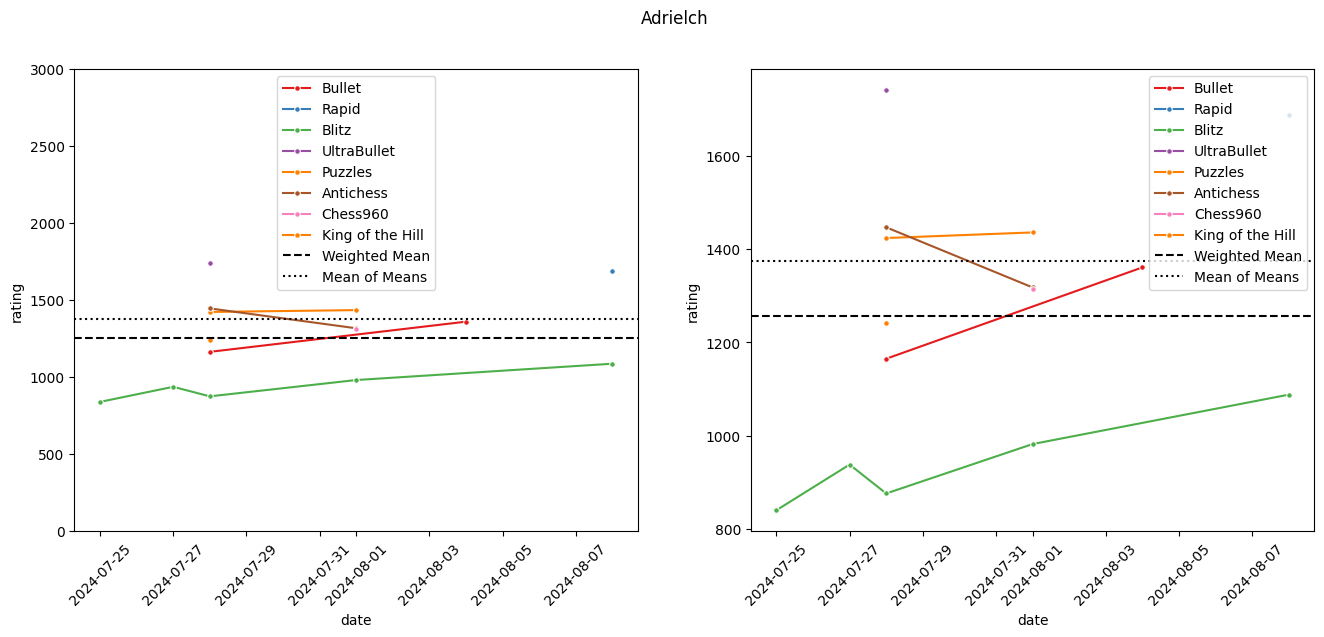

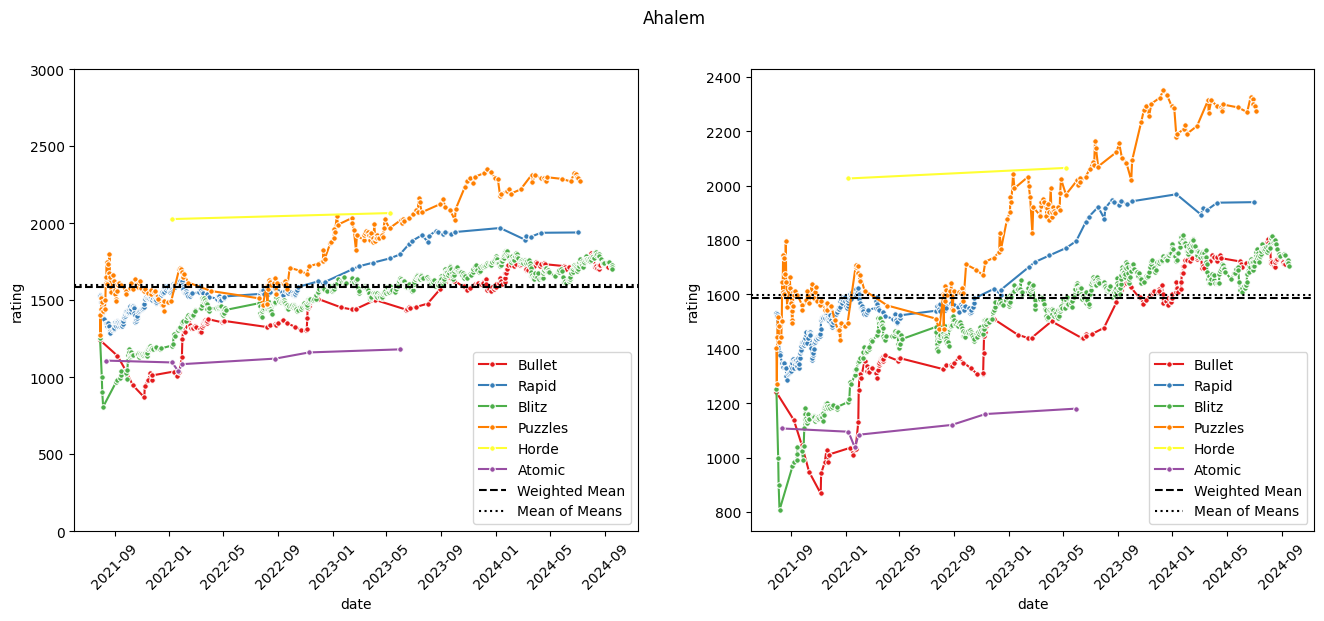

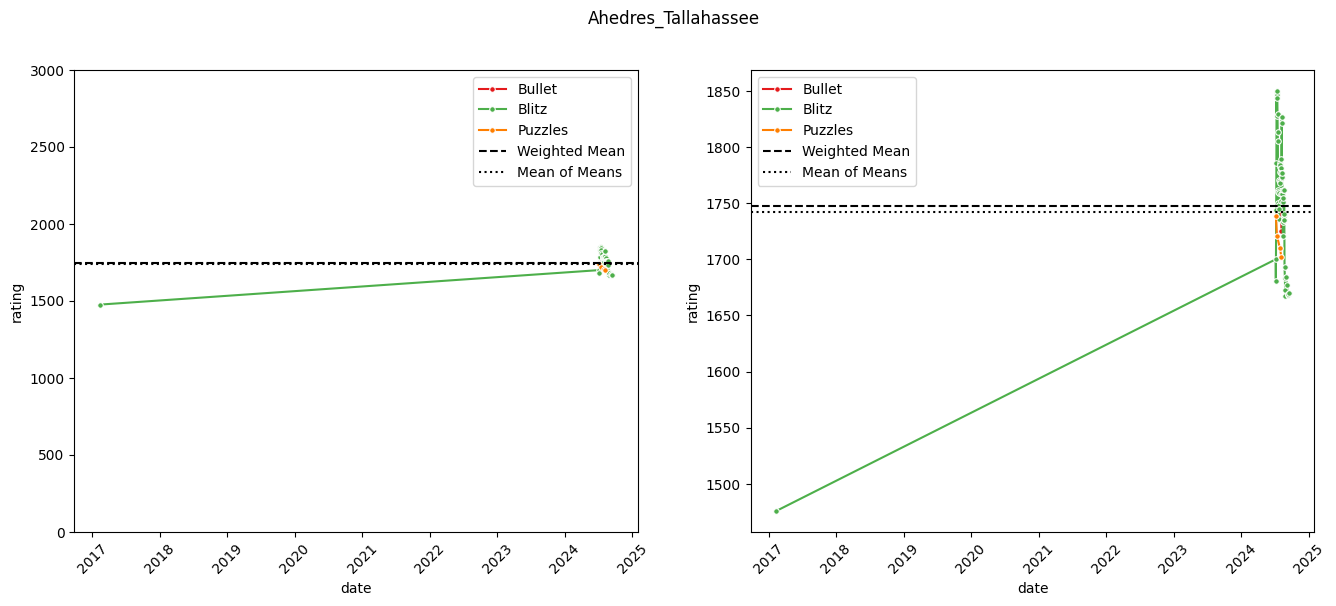

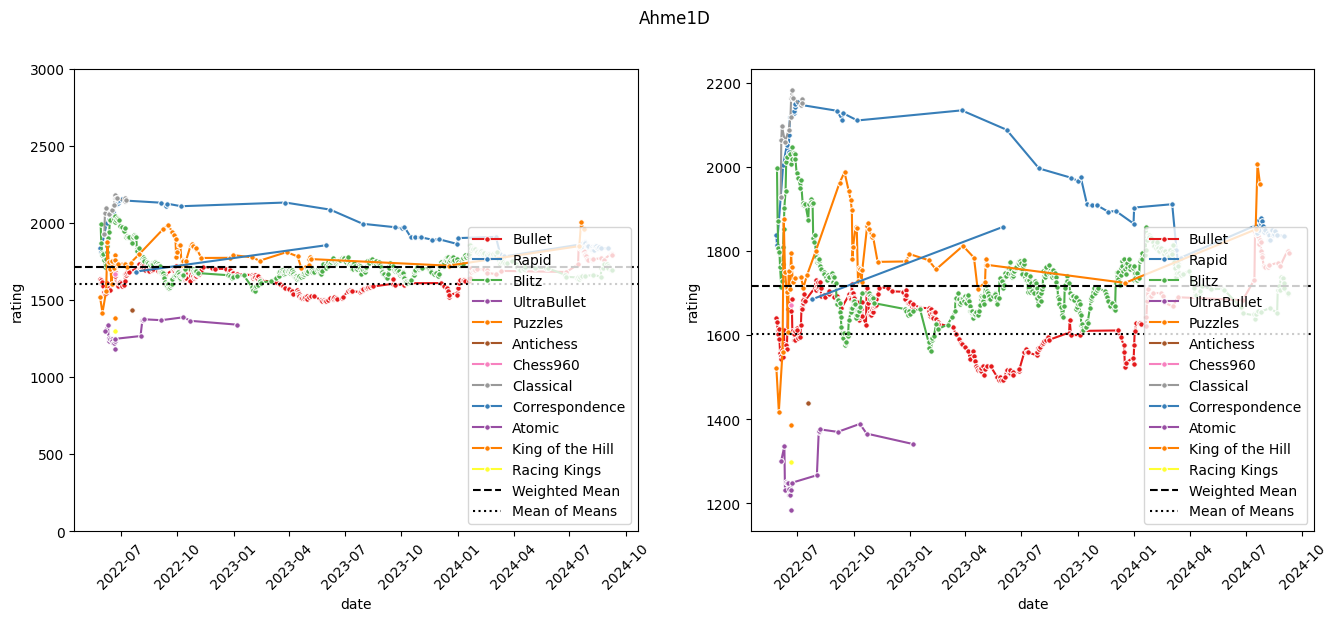

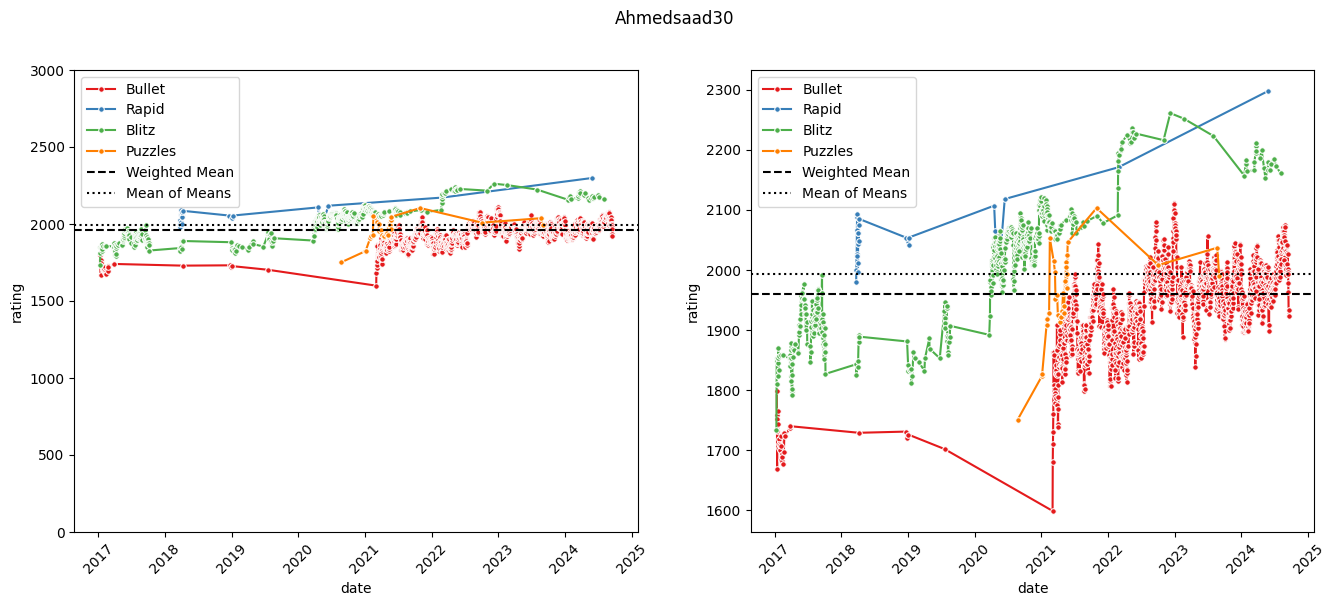

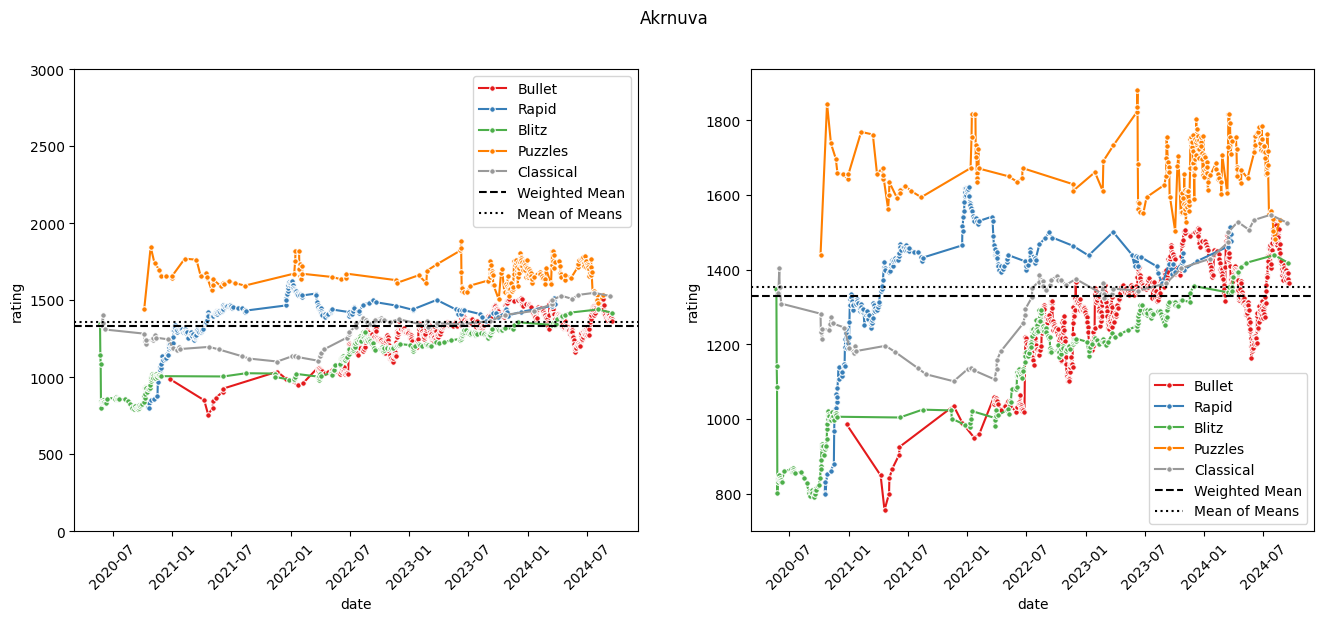

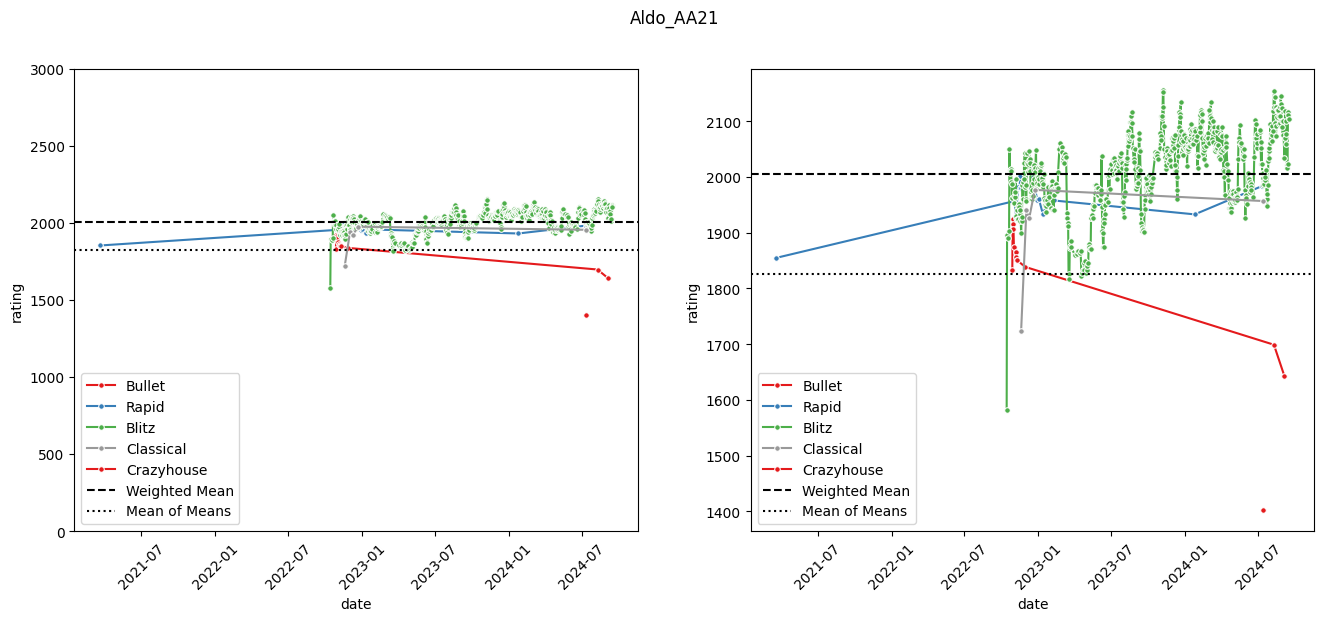

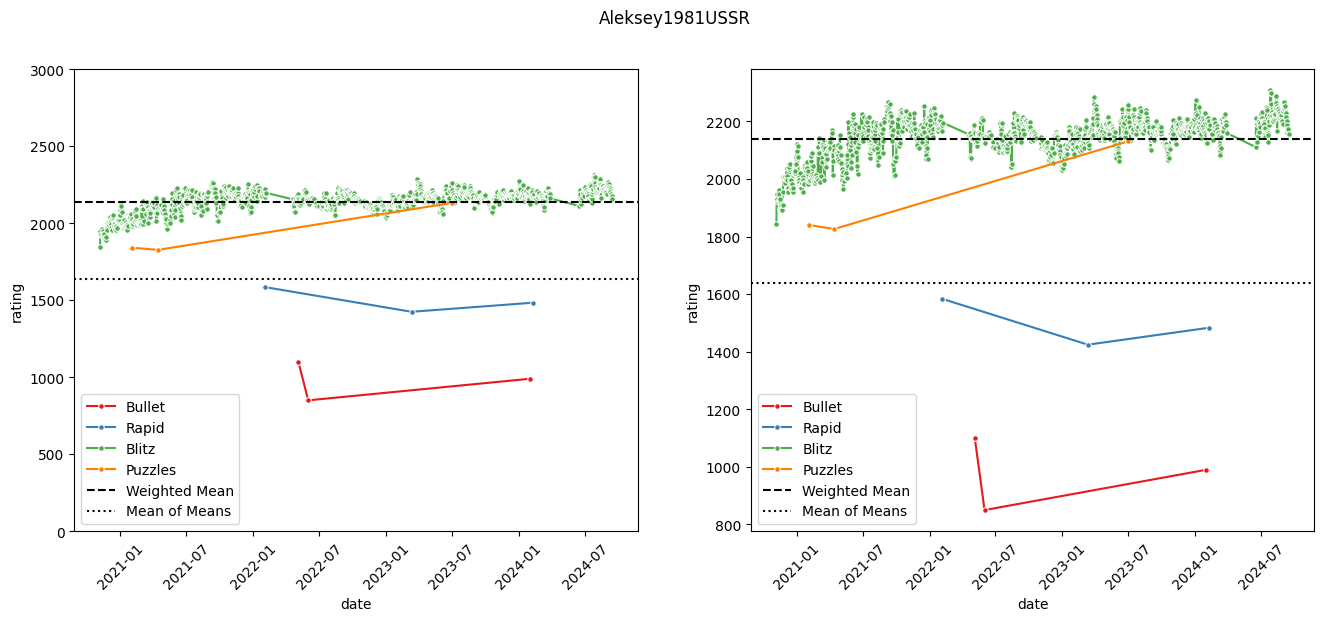

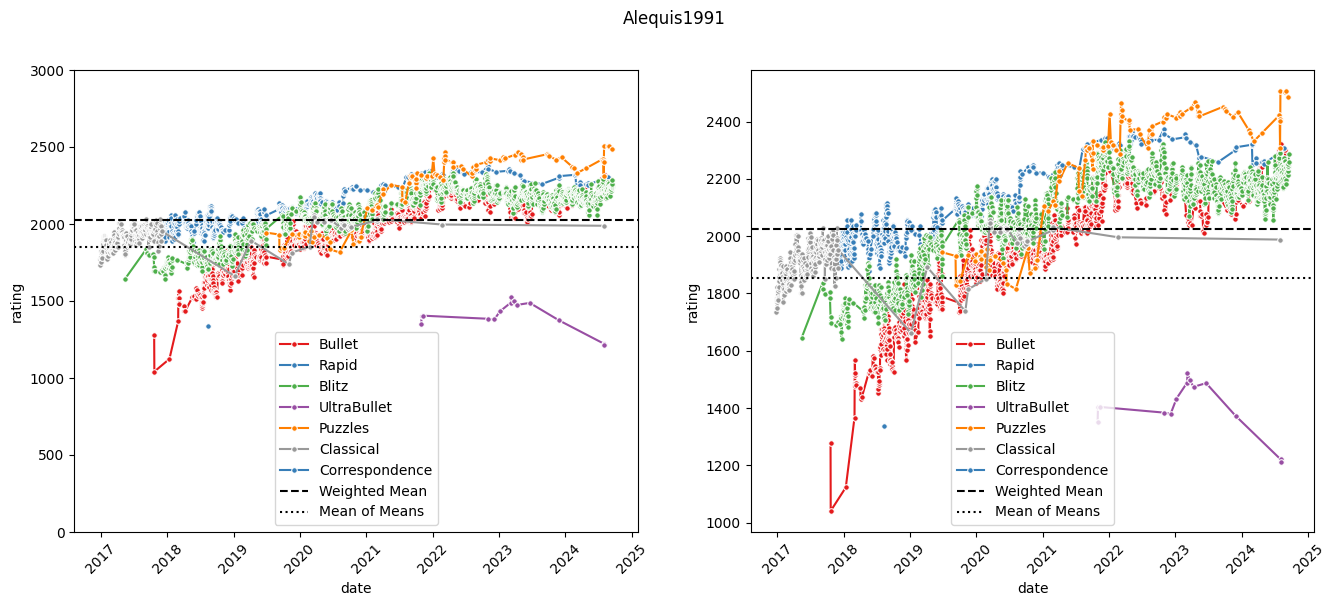

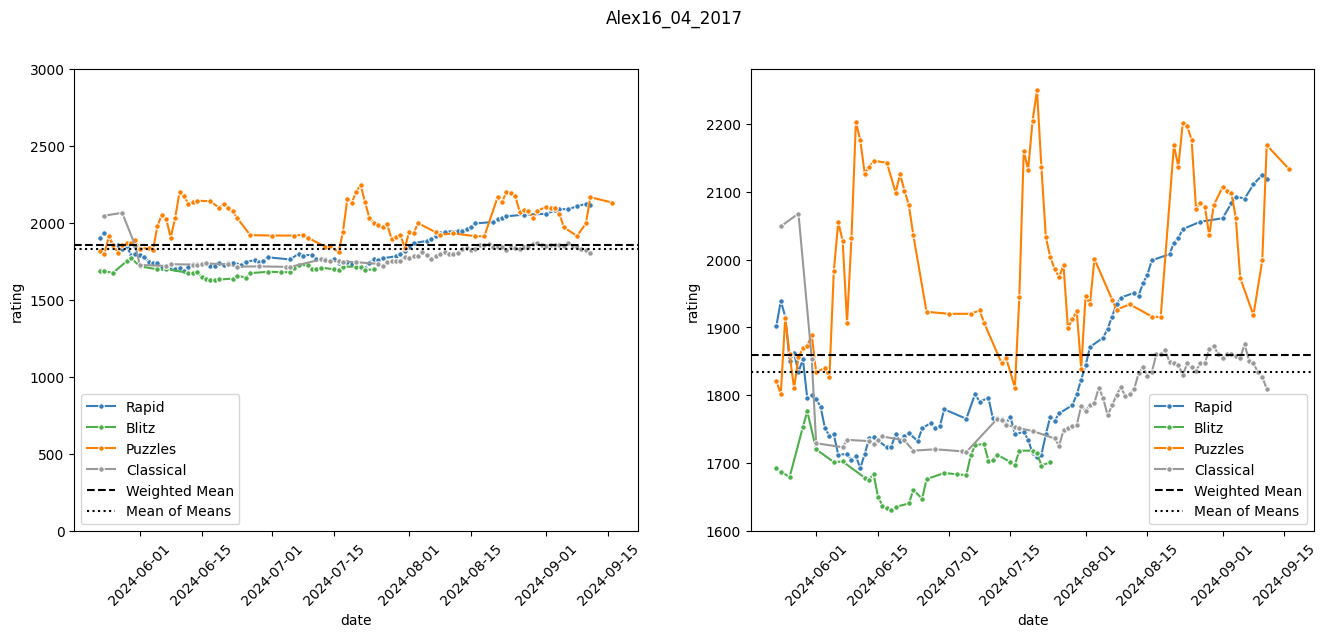

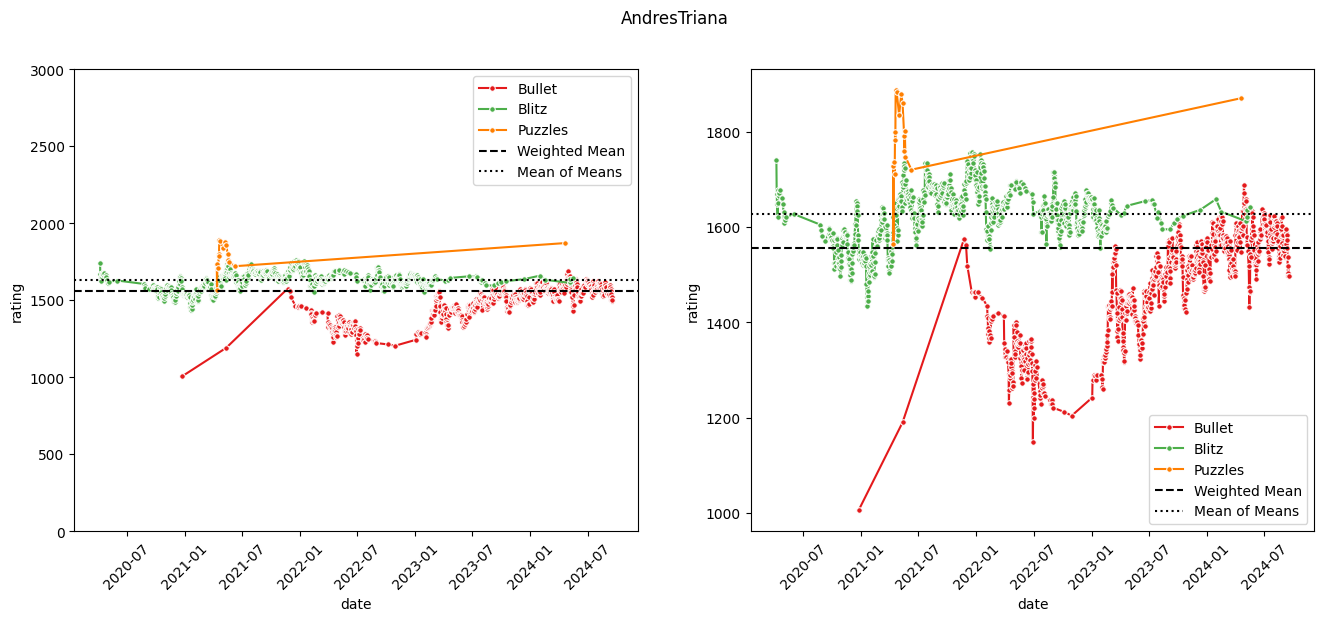

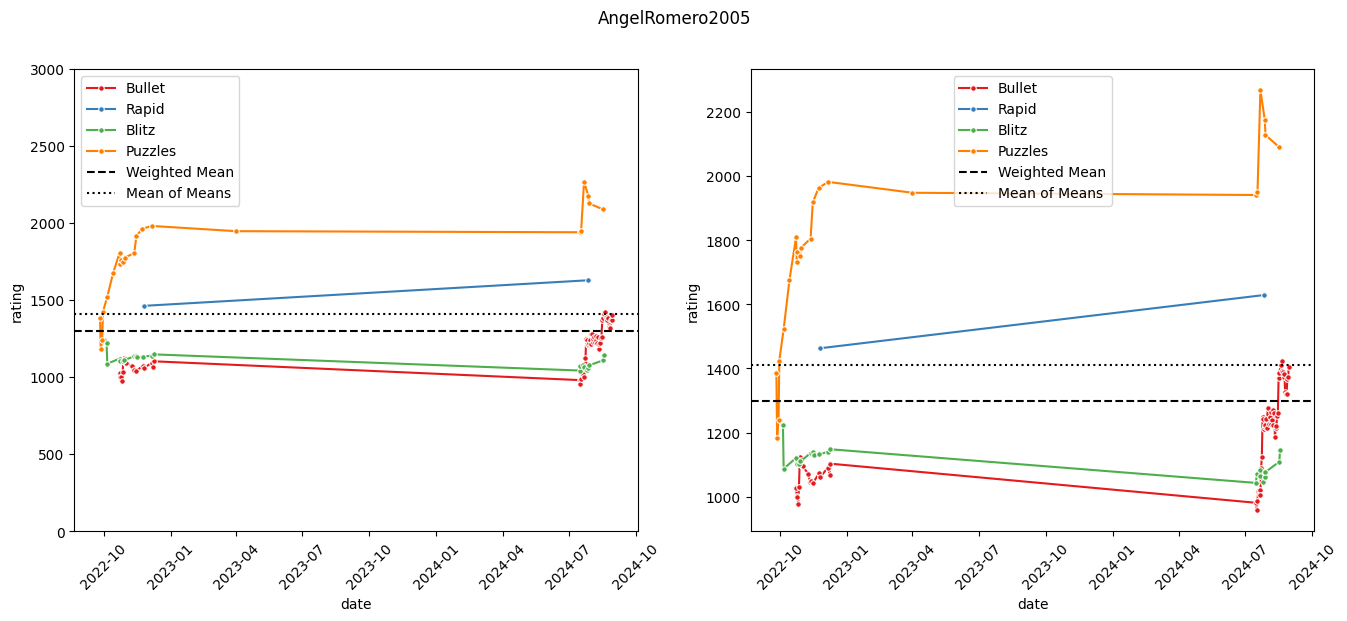

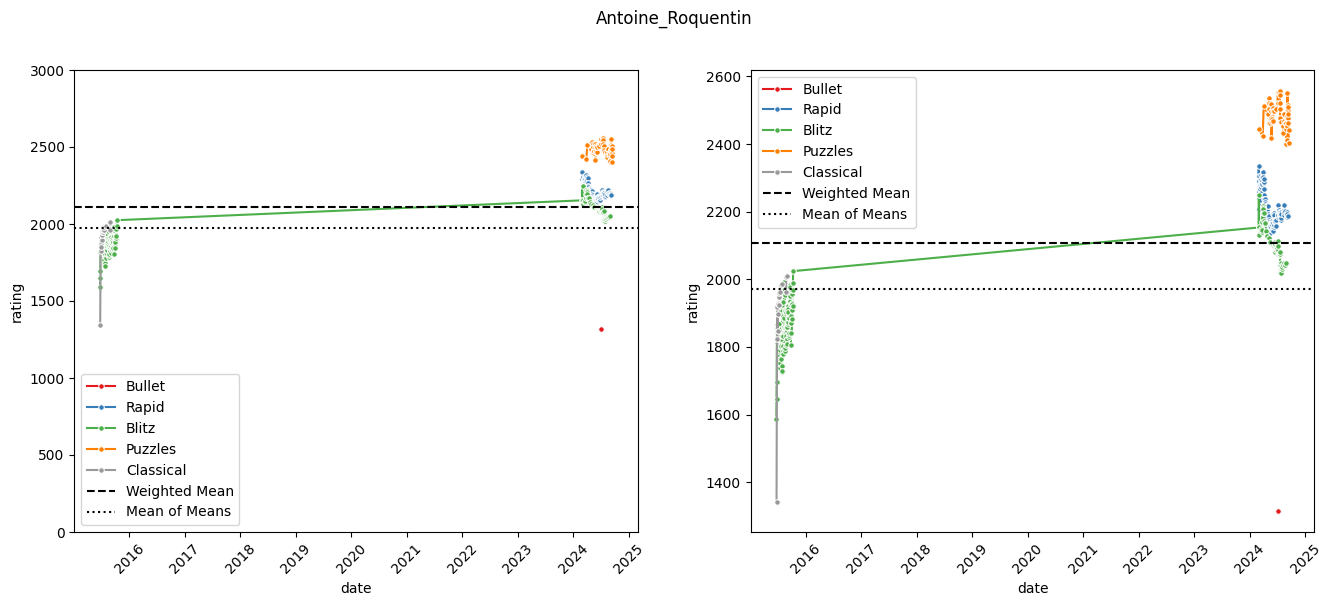

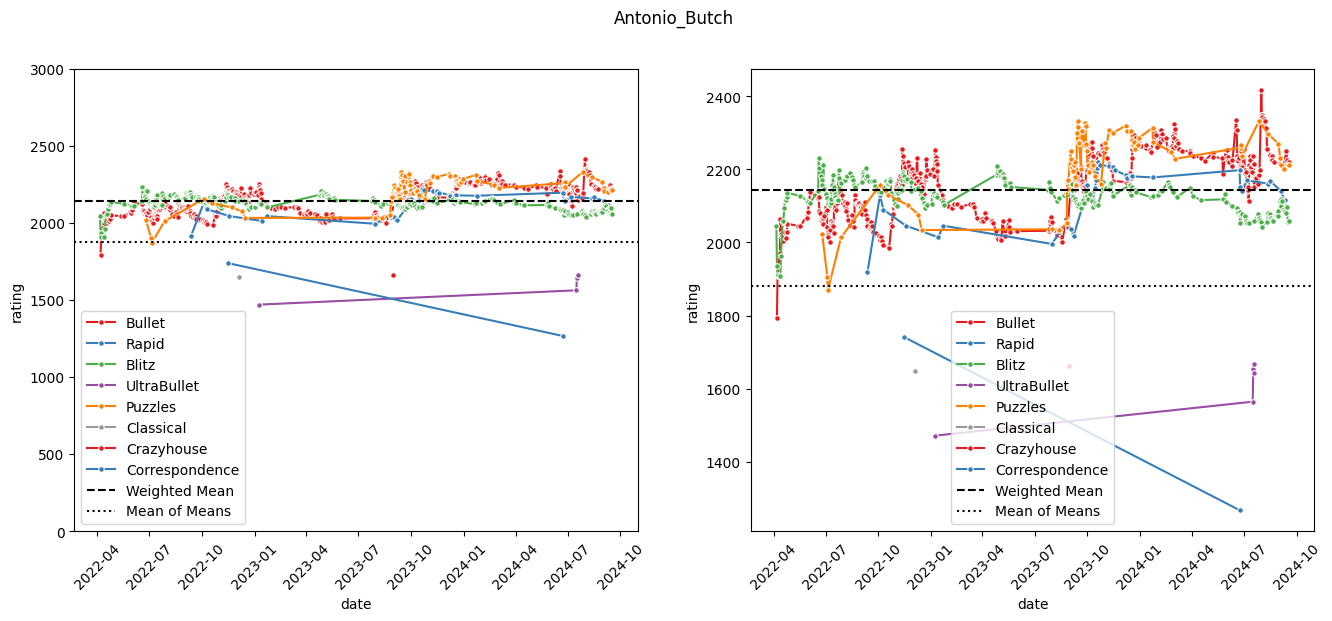

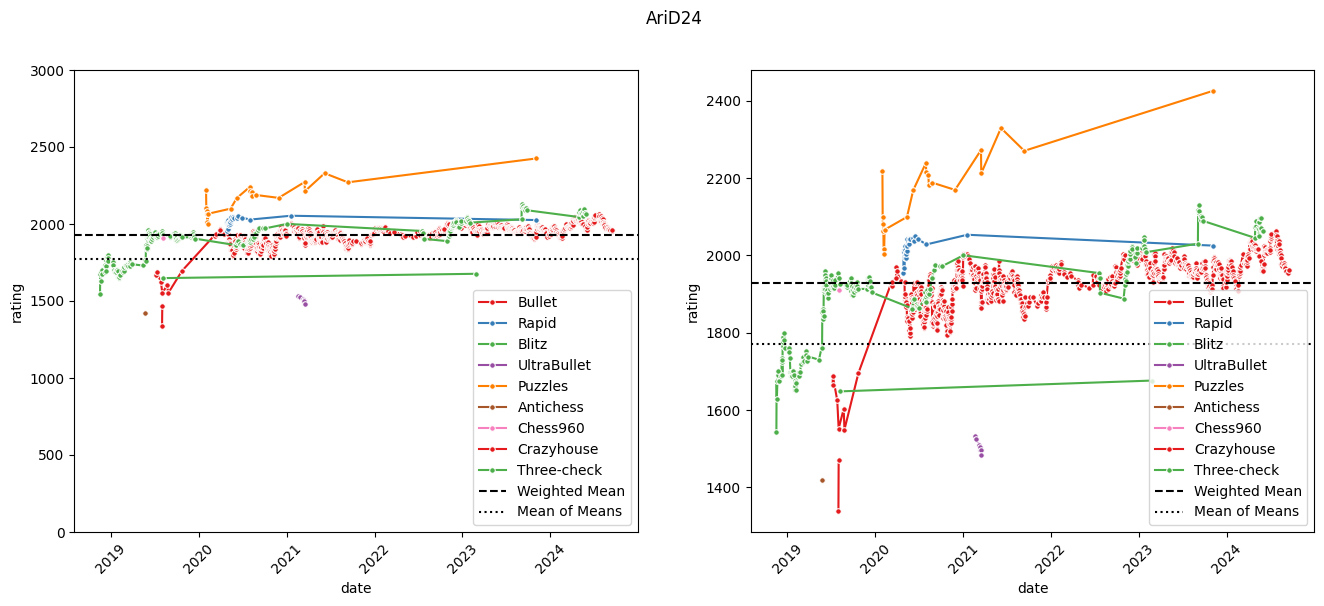

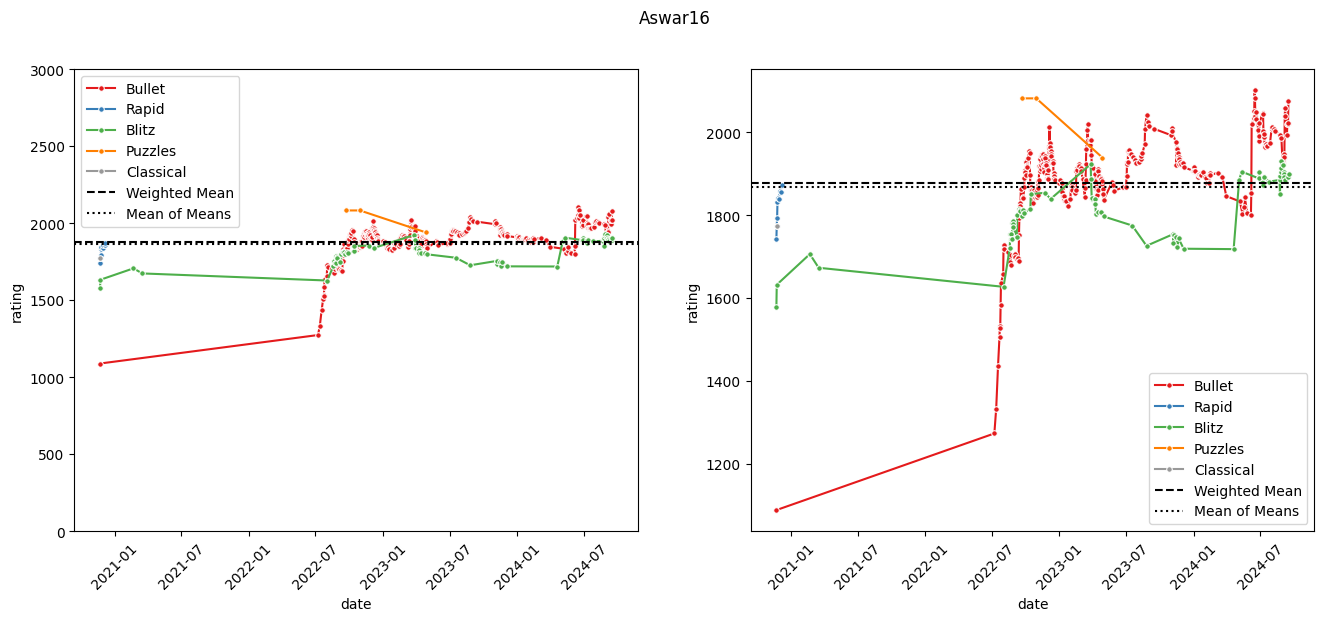

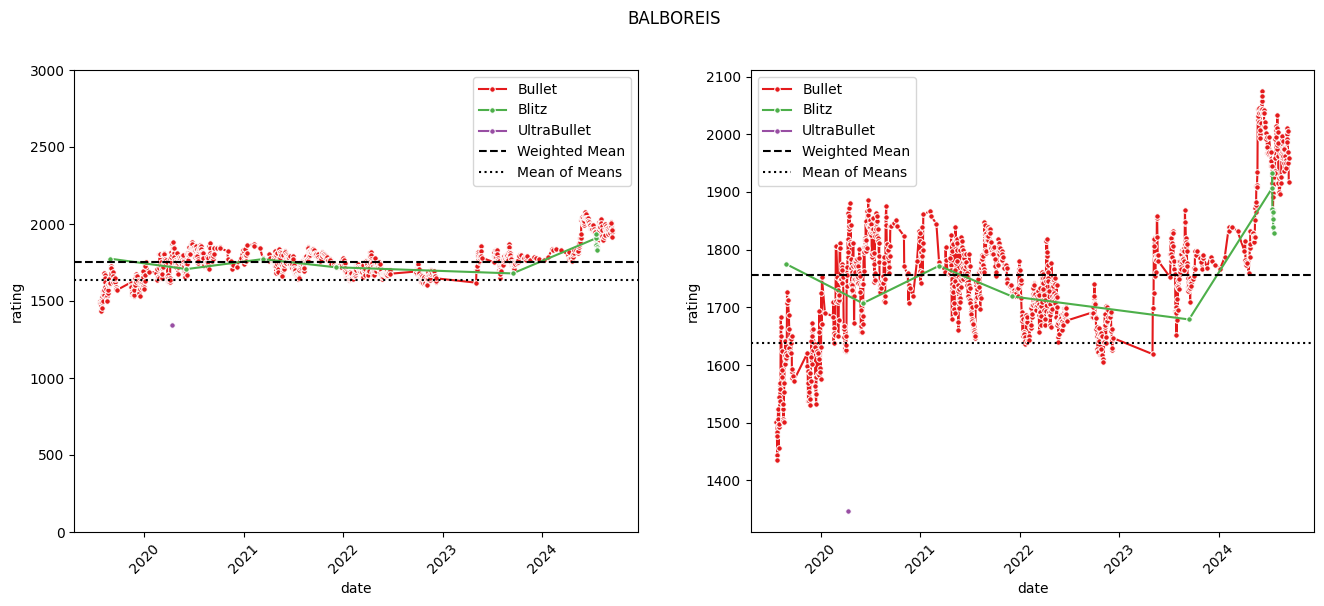

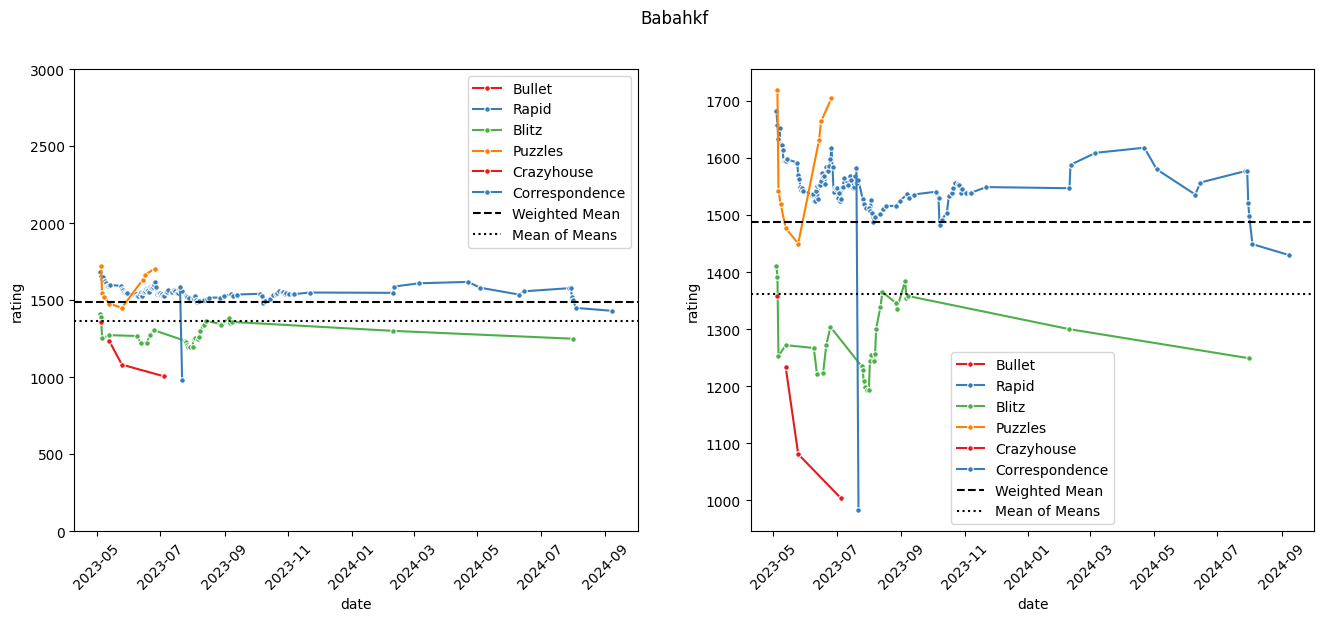

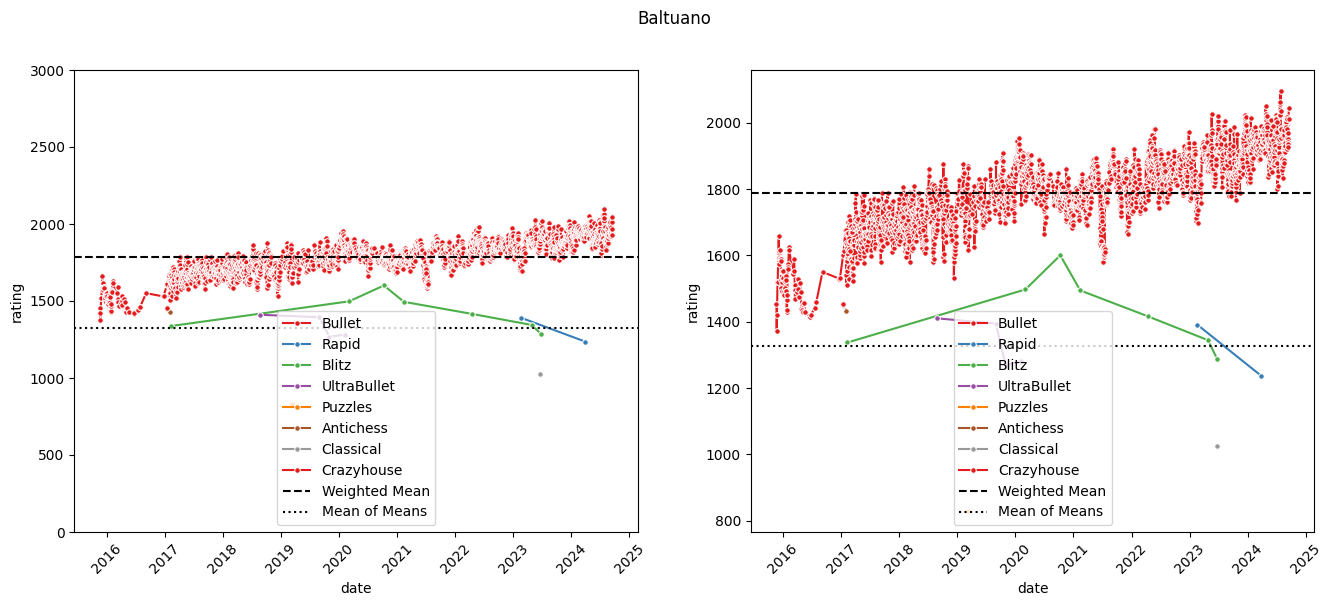

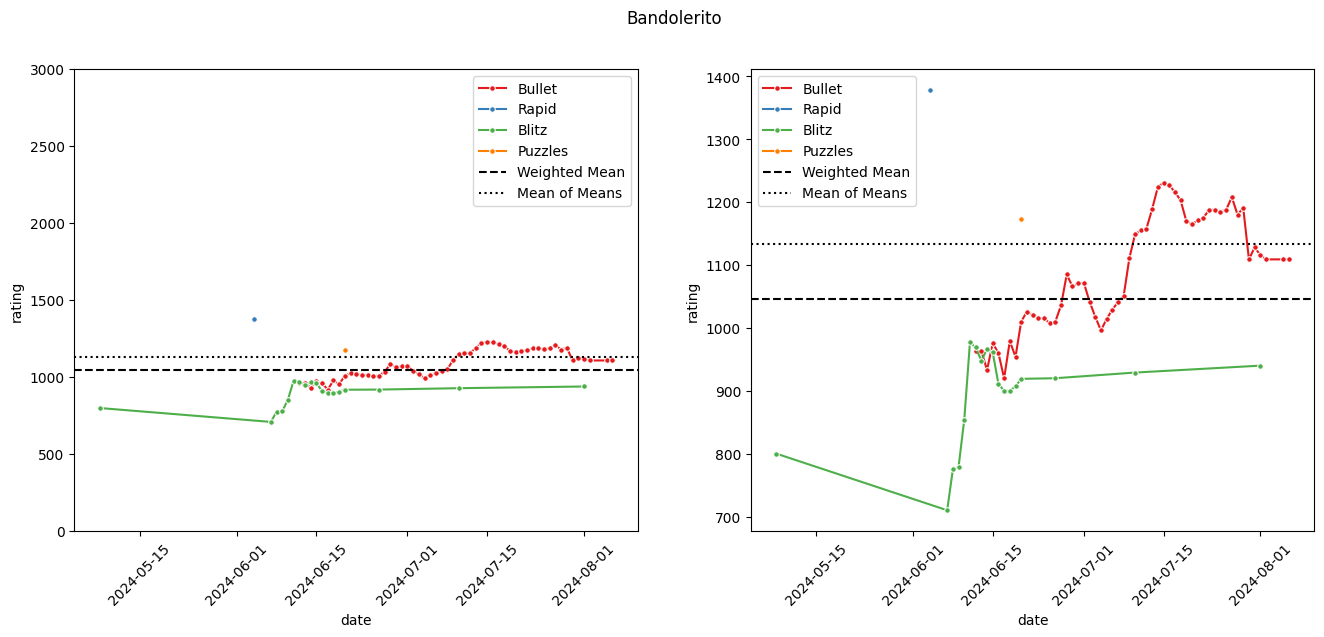

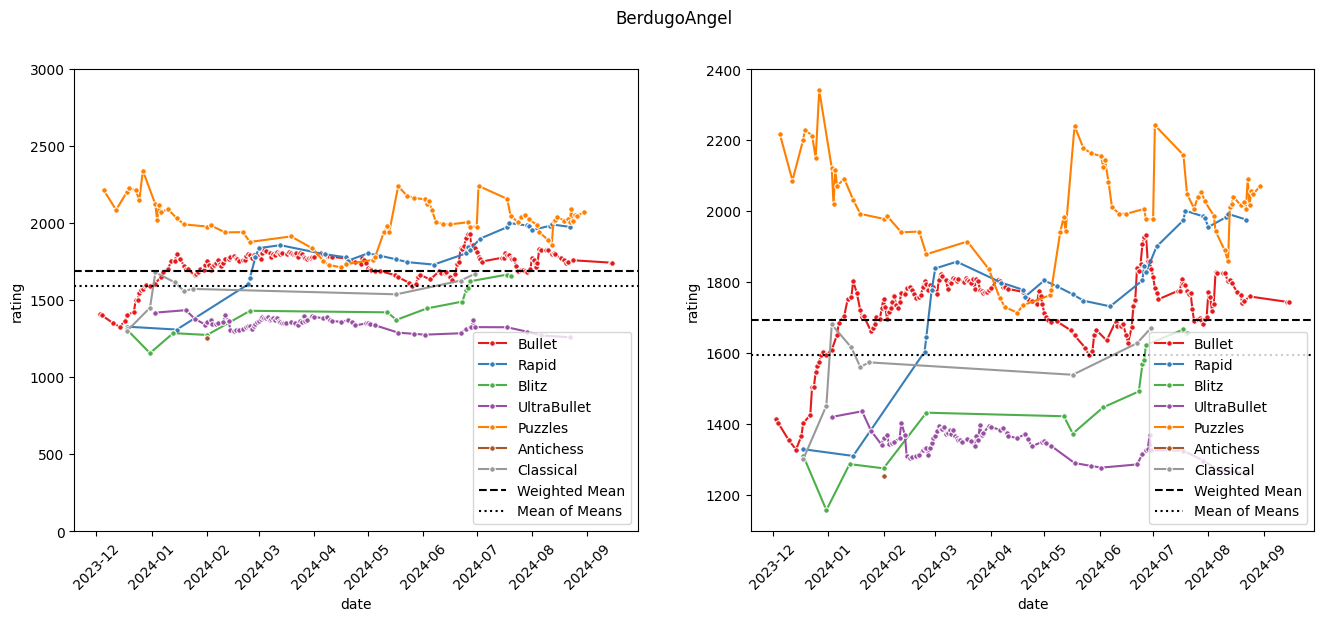

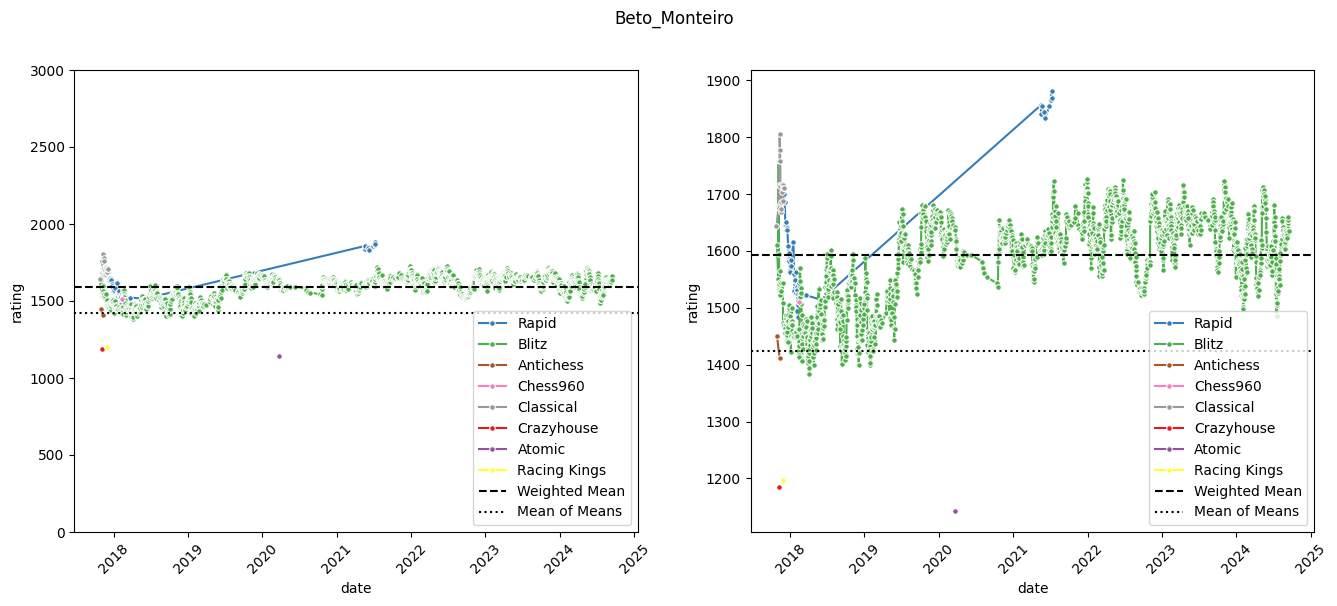

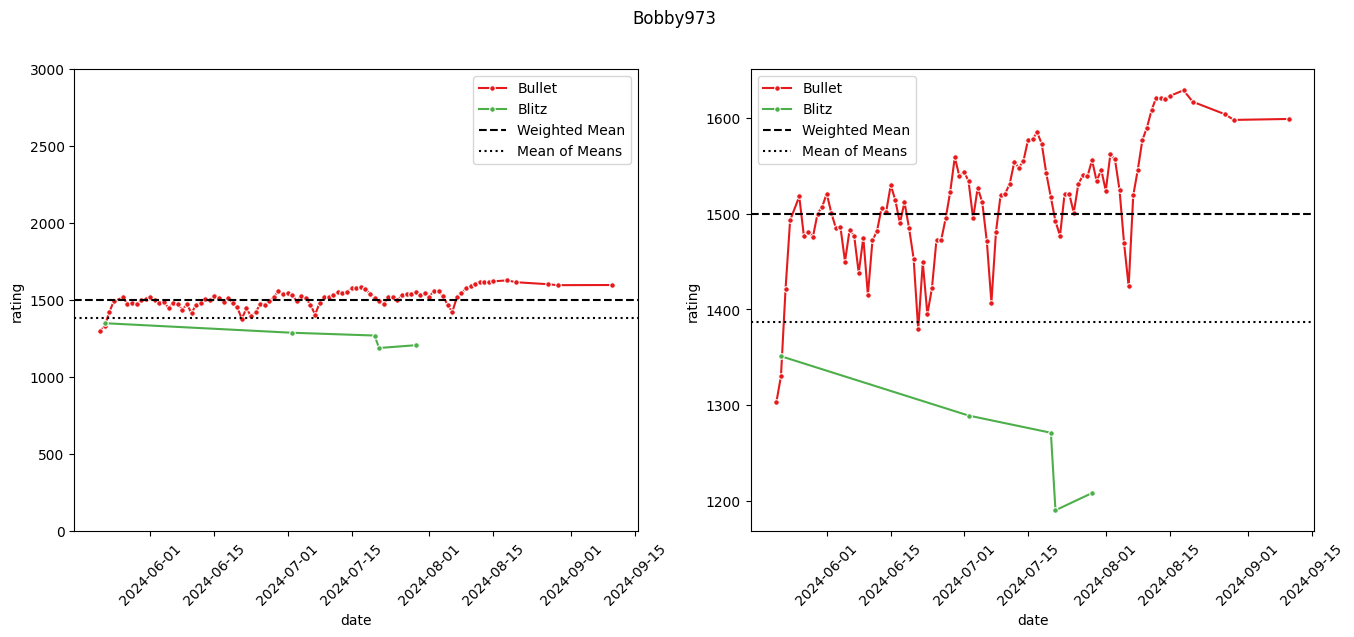

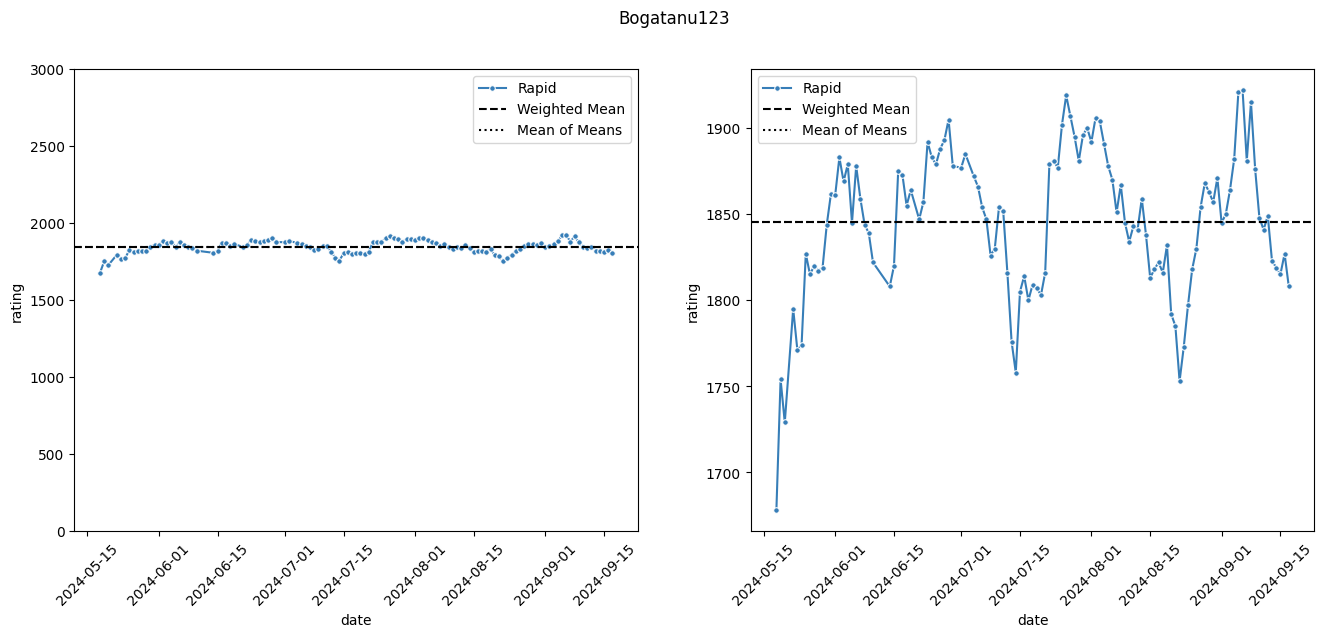

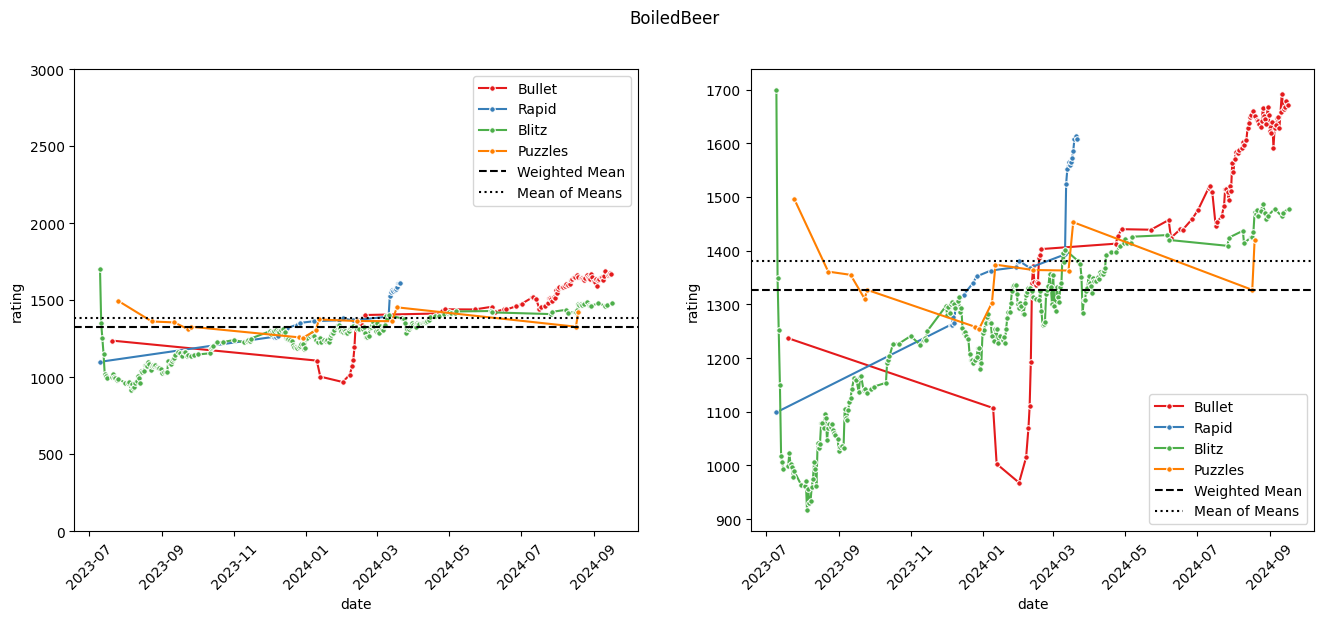

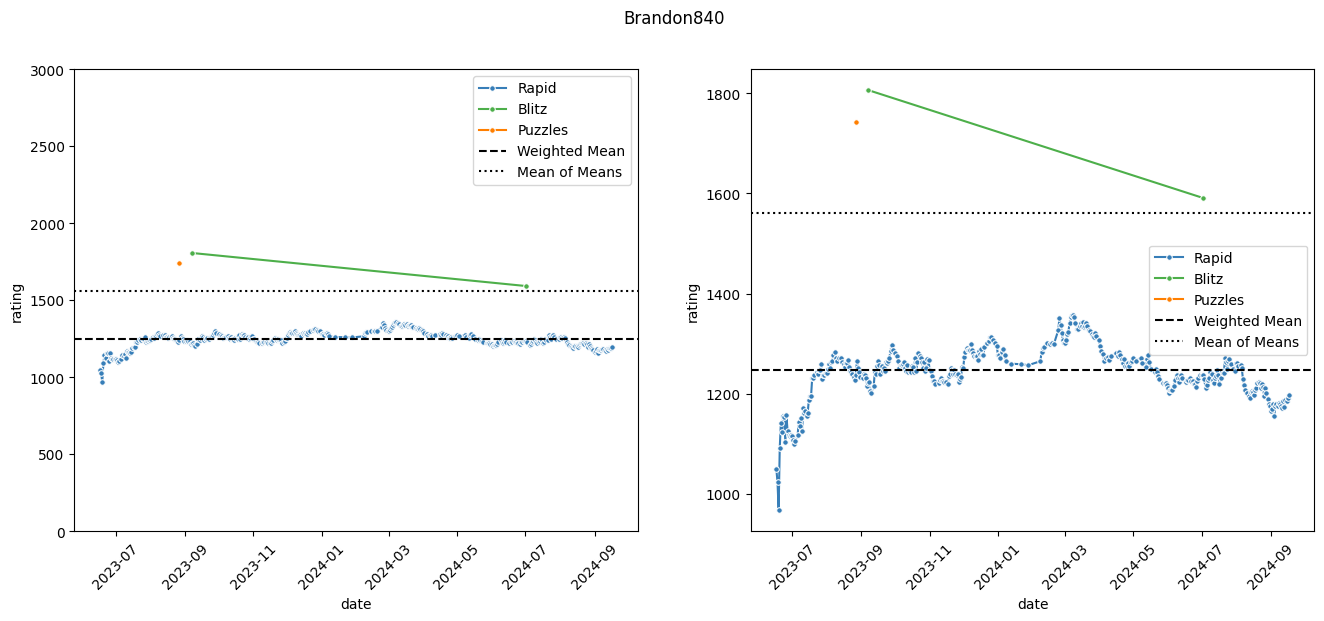

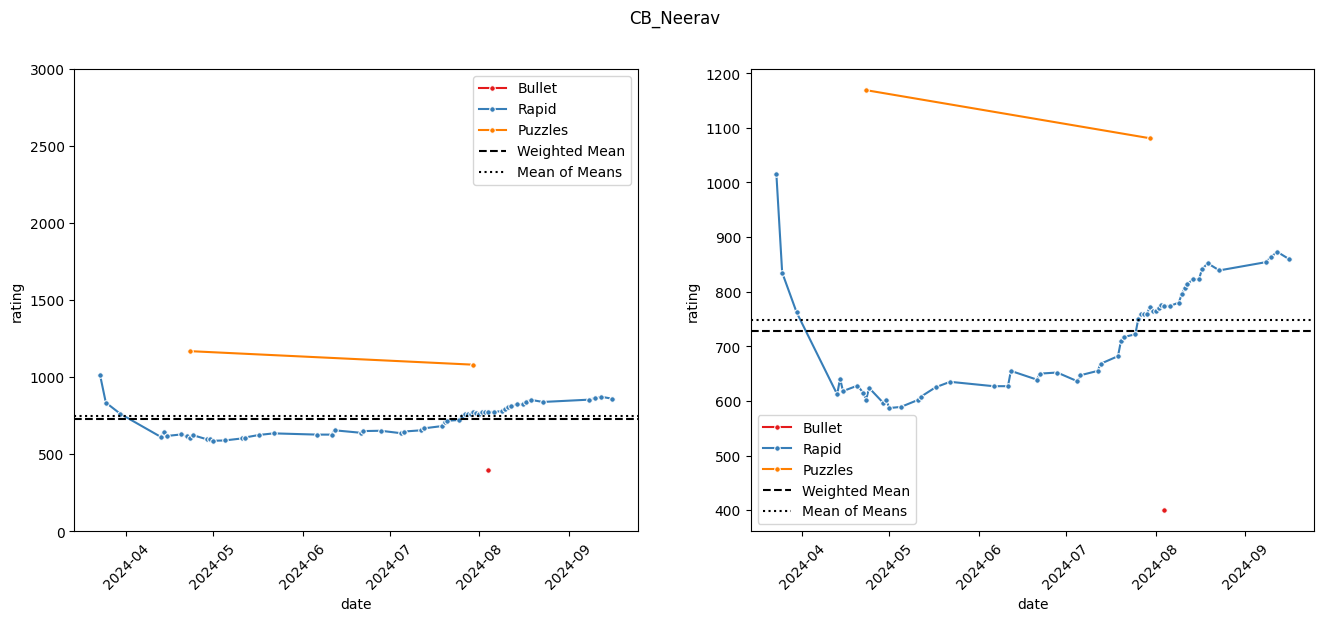

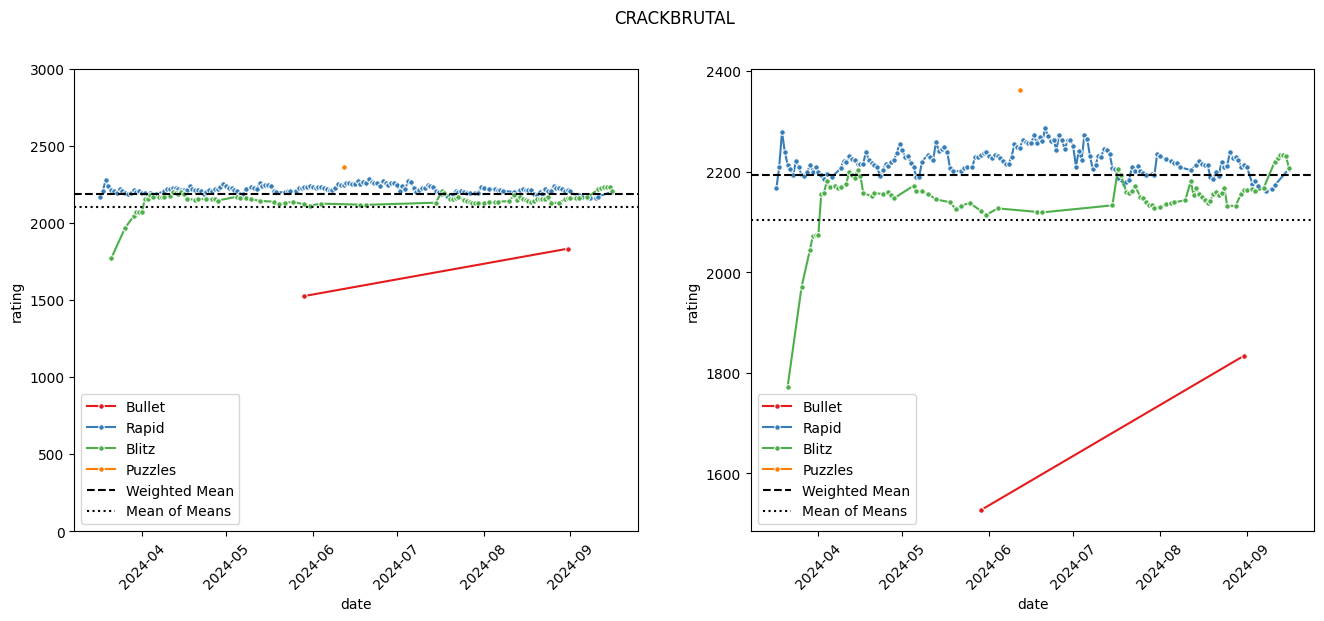

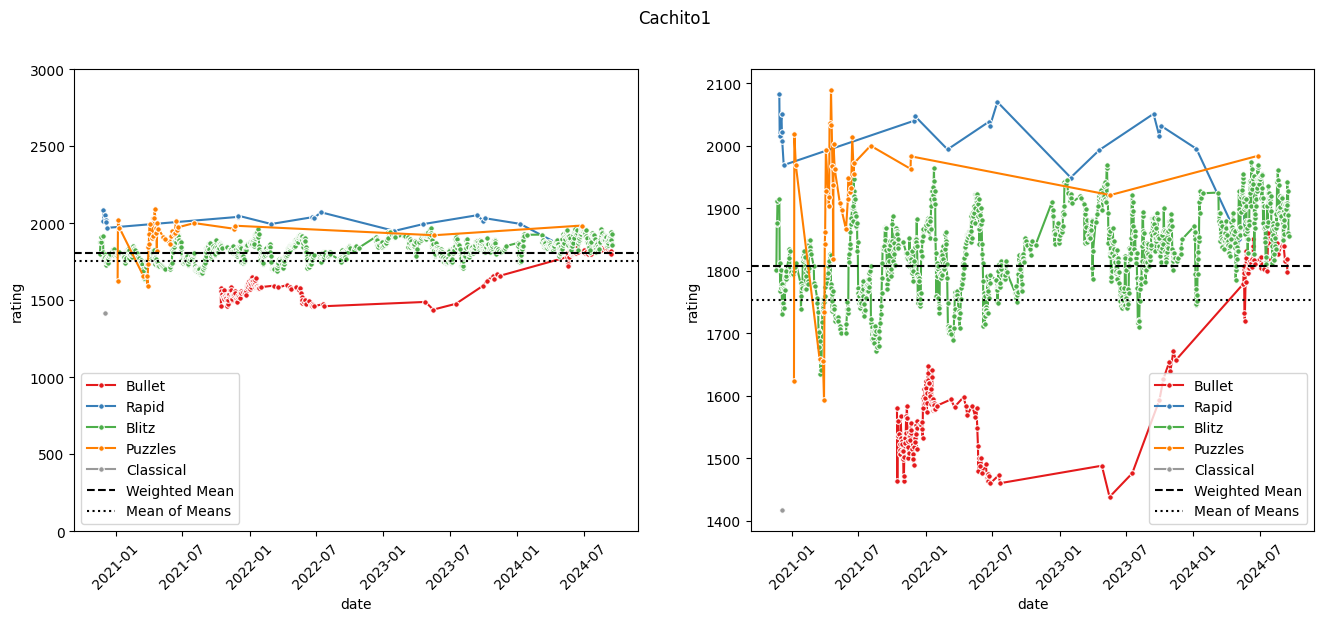

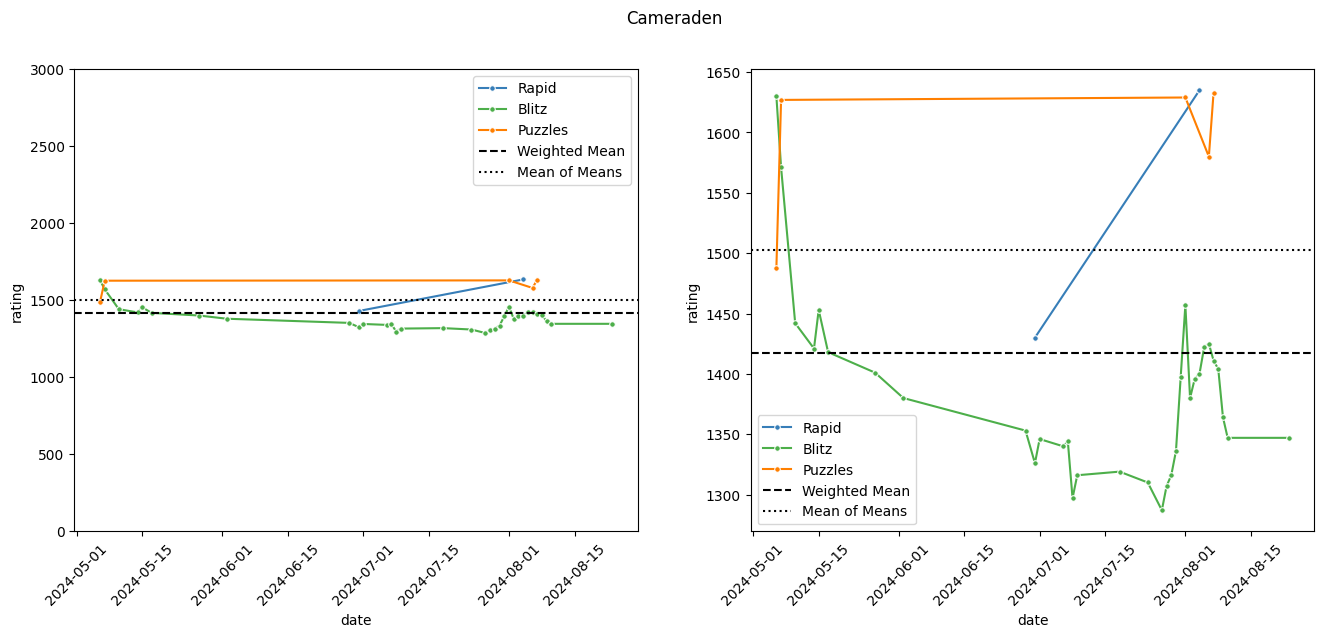

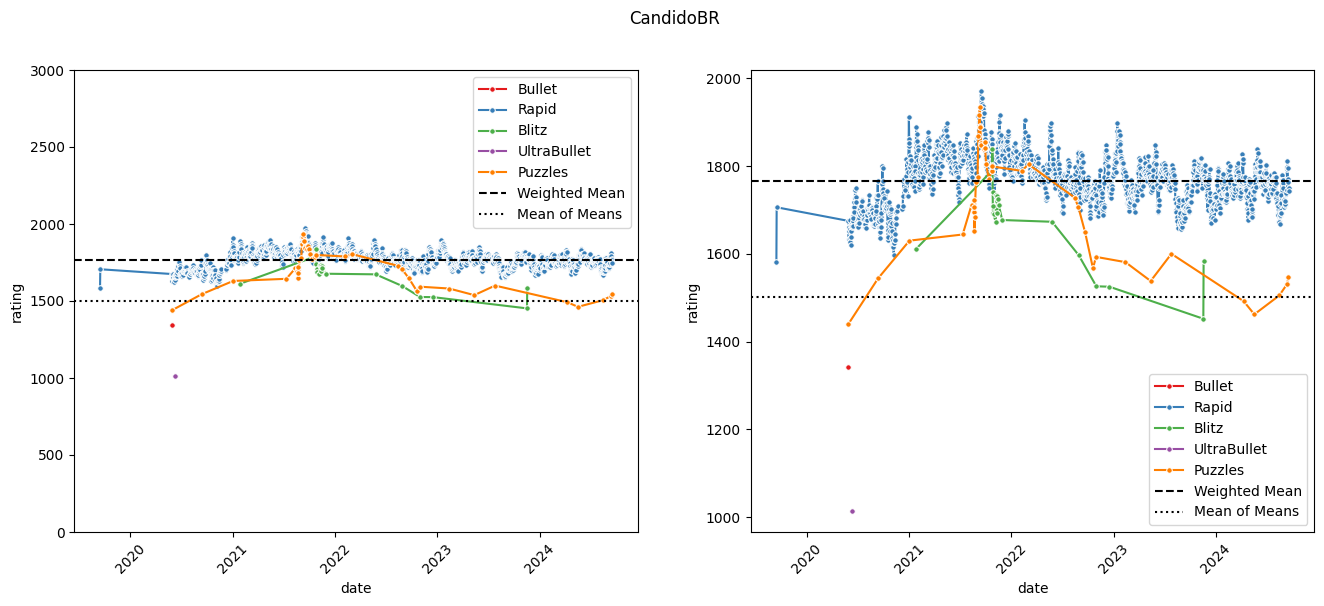

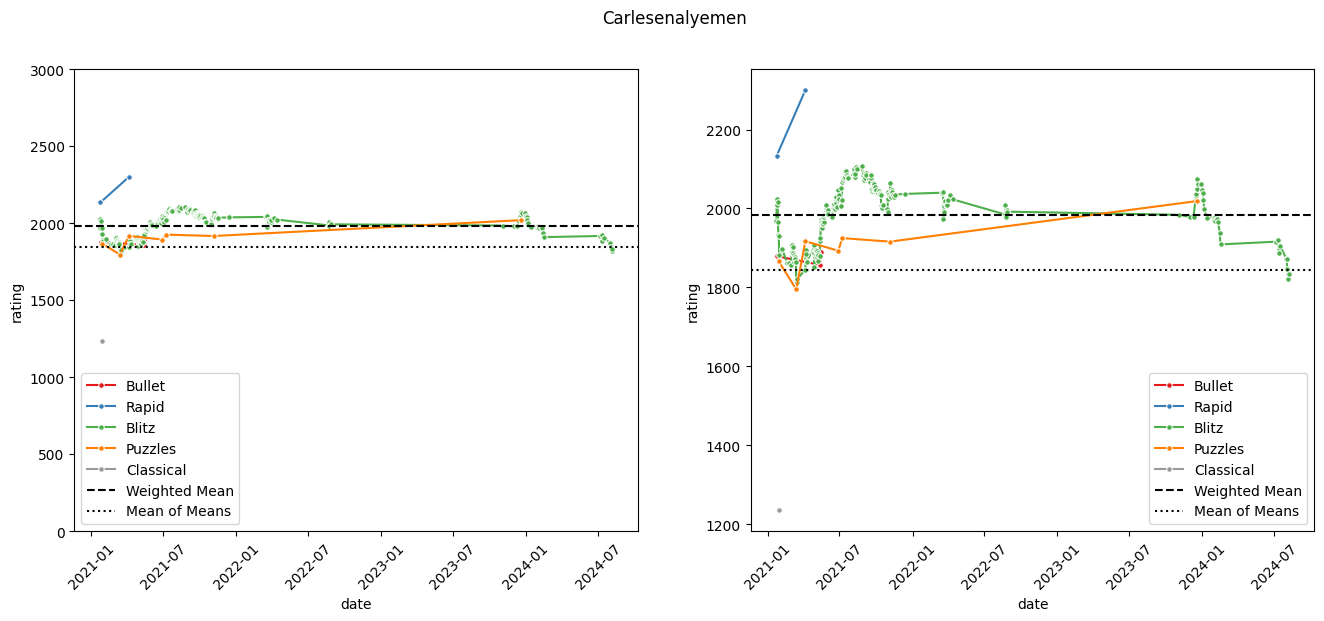

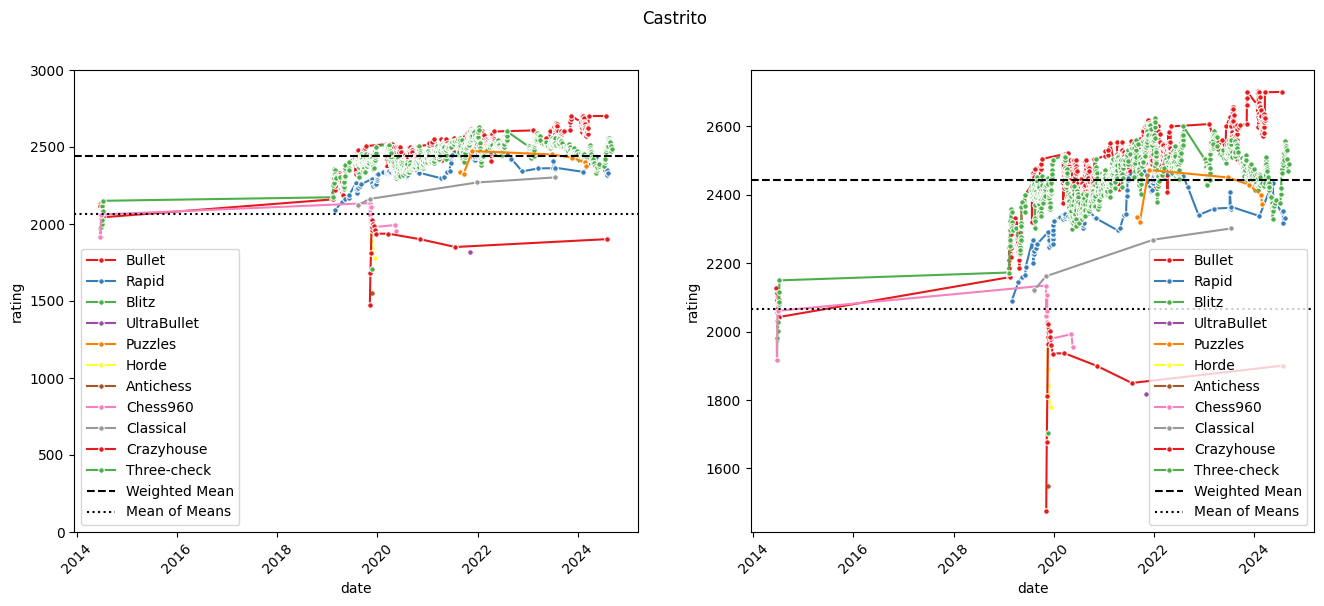

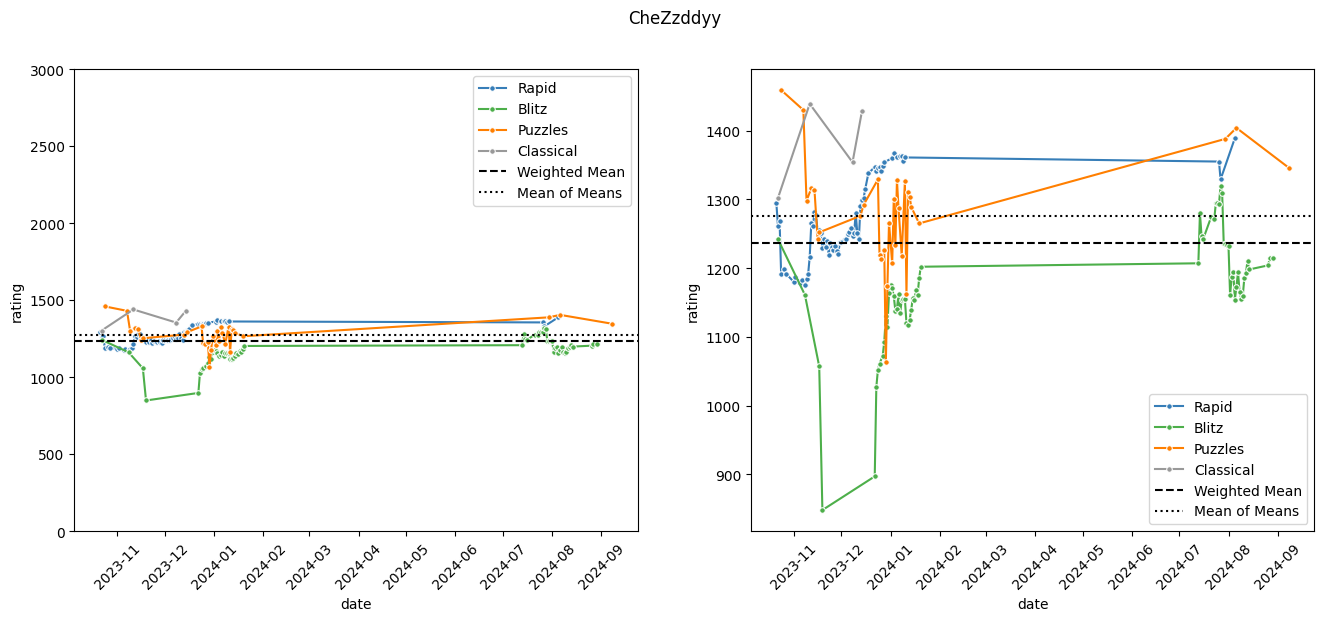

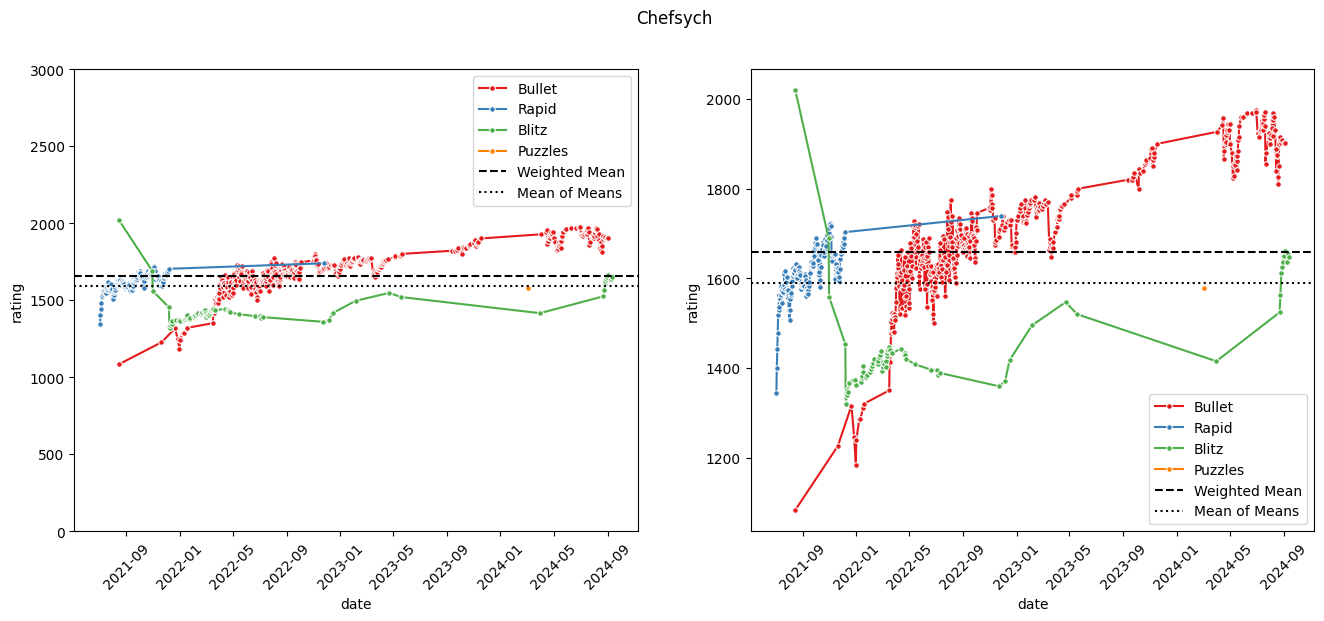

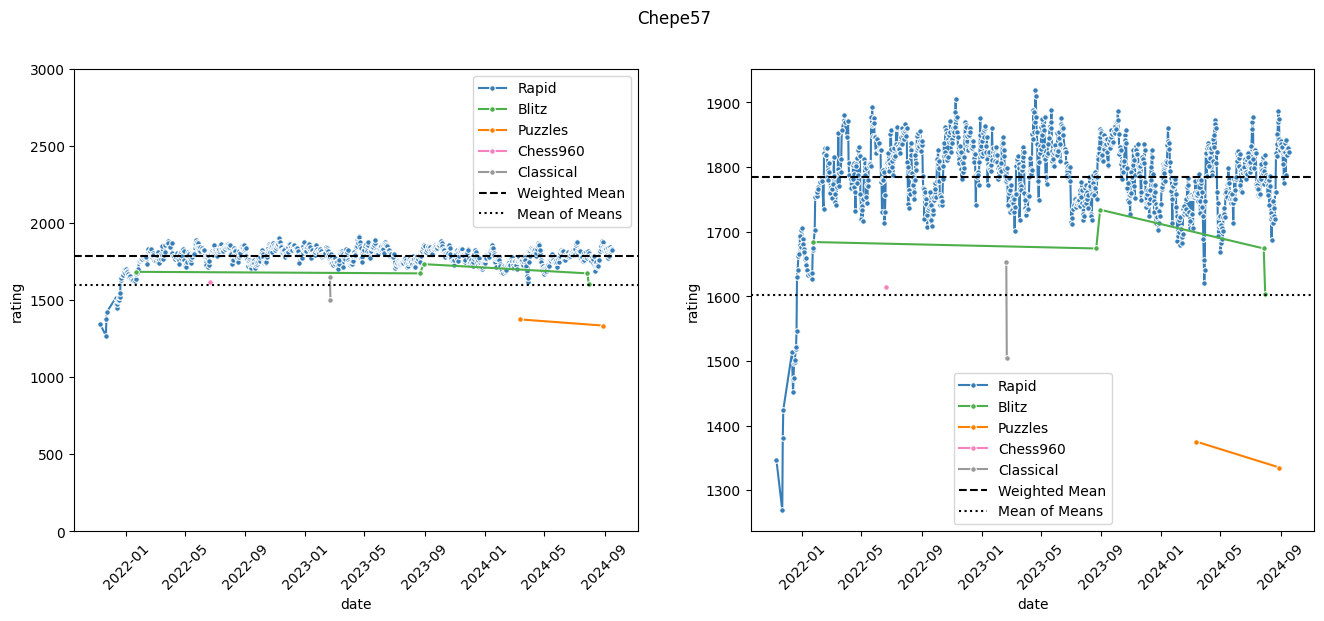

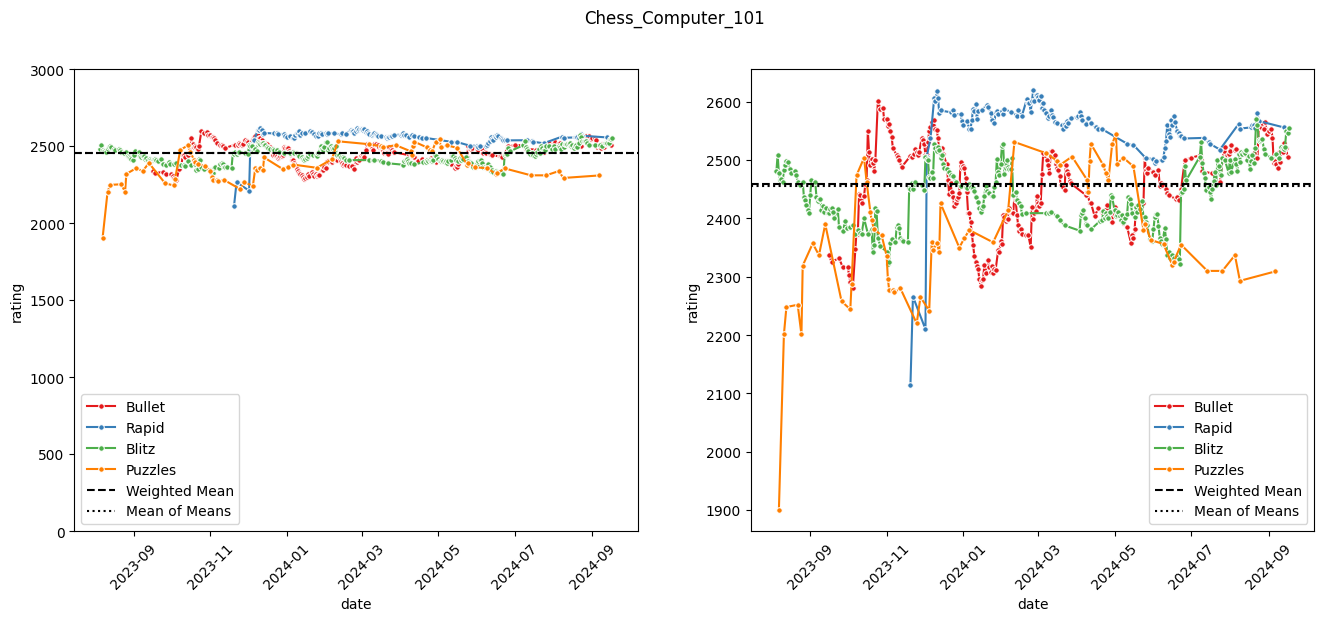

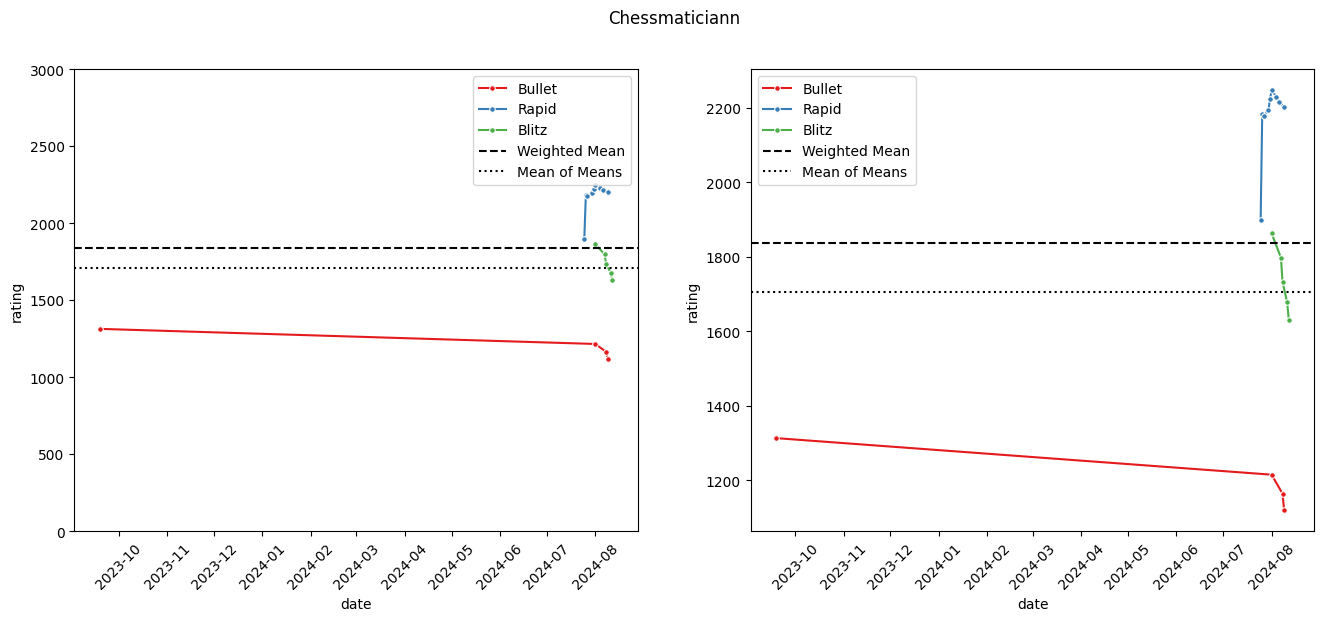

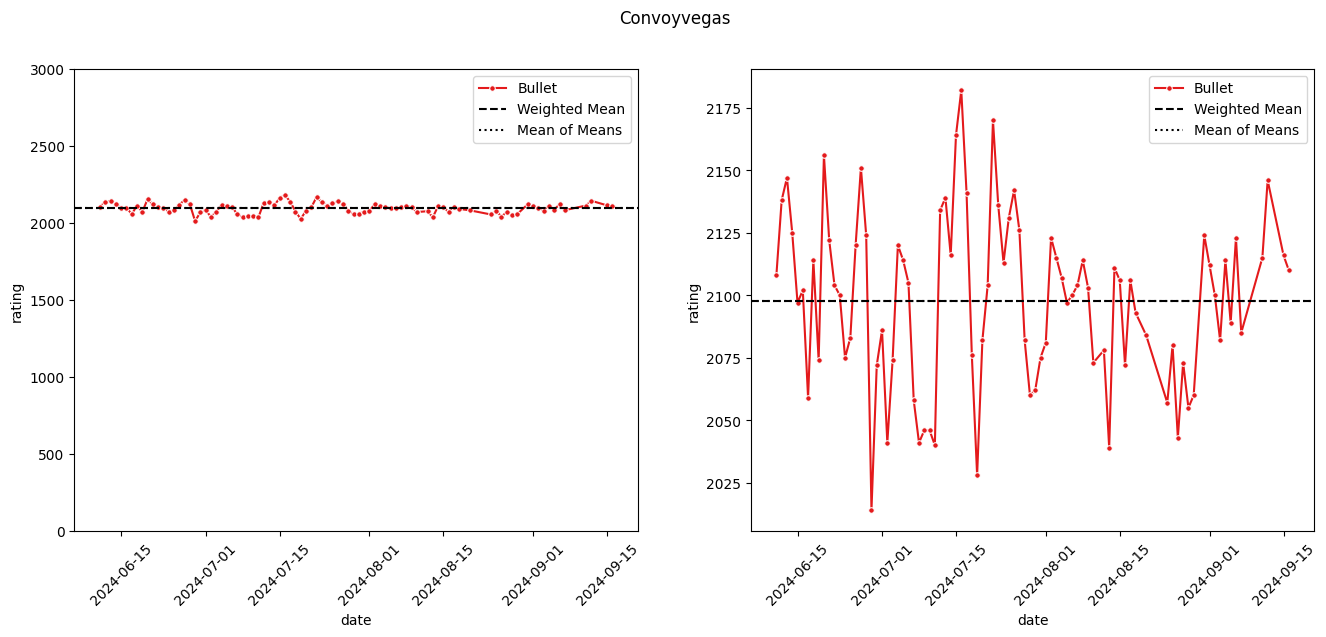

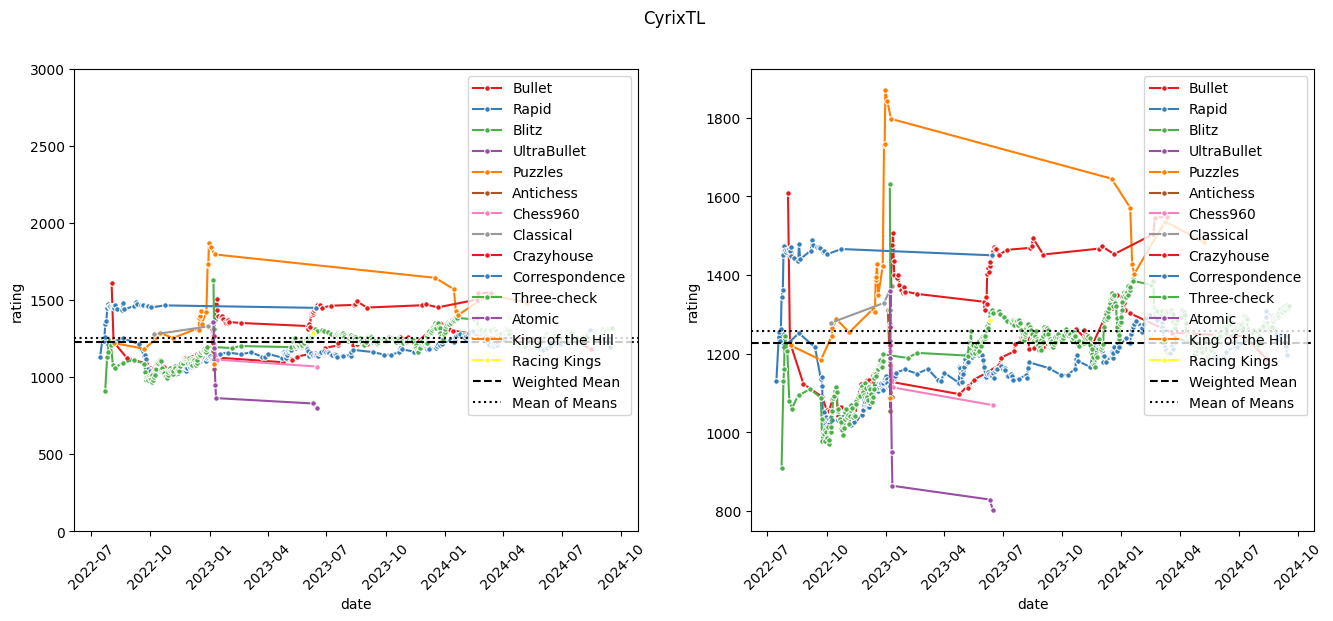

In [35]:
num_cols = 2
num_rows = 25
usernames = all_ratings["username"].unique()
sns.set_palette("Set1")
for user in usernames[:50]:
    fig, ax = plt.subplots(1, 2, figsize=(16,6))
    for i in range(2):
        subset = all_ratings[all_ratings['username'] == user]
        # sort ratings by date:
        subset = subset.sort_values(by='date')
        sns.lineplot(
            subset, 
            x="date", 
            y="rating", 
            hue="mode", 
            hue_order=all_ratings["mode"].unique(), 
            palette="Set1",
            marker=".", 
            markersize= 8, 
            ax=ax[i])
        plt.suptitle(user)
        if i ==0:
            ax[i].set_ylim((0,3000))
        # Add weighted mean:
        weighted_mean_line = ax[i].axhline(subset["rating"].mean(), 0, 1, color="black", linestyle="--", label='Weighted Mean')
        # Add mean of means:
        mean_of_means_line = ax[i].axhline(np.mean(subset.groupby("mode")["rating"].mean()), 0, 1, color="black", linestyle=":", label='Mean of Means')
        
        occurring_modes = subset["mode"].unique()
        handles, labels = ax[i].get_legend_handles_labels()
        indices = [i for i, label in enumerate(labels) if label in occurring_modes]
        line = Line2D([0], [0], label='manual line', color='k')

        ax[i].legend(
            handles=[handles[i] for i in indices]+[weighted_mean_line, mean_of_means_line], 
            labels=[labels[i] for i in indices]+ ['Weighted Mean', 'Mean of Means'])
        ax[i].tick_params(axis='x', rotation=45)
    plt.show()

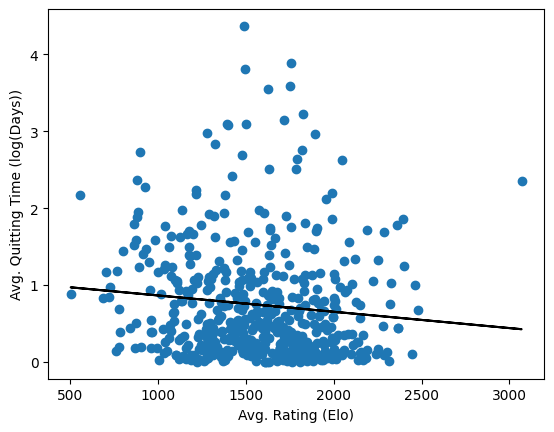

In [32]:
data = all_ratings[["username","rating","days_since_prev"]]
data = data[data["days_since_prev"]> 0]
avg_ratings = data.groupby("username")["rating"].mean()
avg_quitting_times = np.log(data.groupby("username")["days_since_prev"].mean())

# Fit a linear regression using scipy
slope, intercept, r_value, p_value, std_err = stats.linregress(avg_ratings, avg_quitting_times)
# Predict quitting times based on the regression model
regression_line = slope * np.array(avg_ratings) + intercept
_ = plt.scatter(avg_ratings, avg_quitting_times)
_ = plt.plot(avg_ratings, regression_line, color='black', label='Fitted line')
_ = plt.xlabel("Avg. Rating (Elo)")
_ = plt.ylabel("Avg. Quitting Time (log(Days))")


In [33]:
print(stats.linregress(avg_ratings, avg_quitting_times))

LinregressResult(slope=-0.00021195439603014594, intercept=1.0761019253407578, rvalue=-0.1090286197682347, pvalue=0.01502557606274154, stderr=8.685654873443564e-05, intercept_stderr=0.13998826629532798)


LinregressResult(slope=-0.0001917263363898339, intercept=0.7674539080625751, rvalue=-0.08555107432619466, pvalue=0.05665985885812938, stderr=0.0001003595173985966, intercept_stderr=0.03525937789028438)


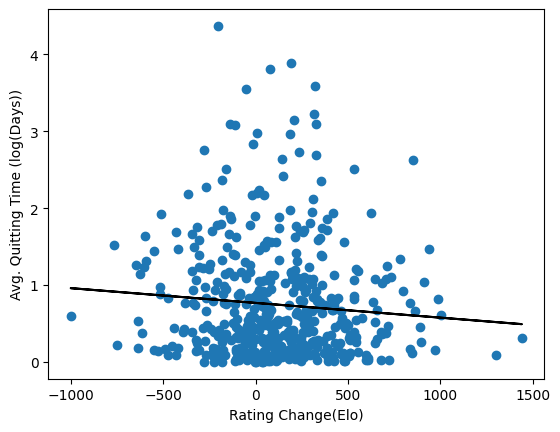

In [25]:
start_rating = list(all_ratings.loc[all_ratings.groupby('username')['date'].idxmin(), "rating"] )
end_rating = list(all_ratings.loc[all_ratings.groupby('username')['date'].idxmax(), "rating"])
rating_change = [end- start for start, end in zip(start_rating, end_rating)]

# Fit a linear regression using scipy
slope, intercept, r_value, p_value, std_err = stats.linregress(rating_change, avg_quitting_times)
print(stats.linregress(rating_change, avg_quitting_times))
# Predict quitting times based on the regression model
regression_line = slope * np.array(rating_change) + intercept
_ = plt.scatter(rating_change, avg_quitting_times)
_ = plt.plot(rating_change, regression_line, color='black', label='Fitted line')
_ = plt.xlabel("Rating Change(Elo)")
_ = plt.ylabel("Avg. Quitting Time (log(Days))")

In [168]:
all_ratings.to_csv("../data/all_ratings_users_active_in_Aug24.csv", index=False)